# Wikipedia Web Traffic Data

The dataset is available [on Kaggle](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data)

In [170]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## Imports and reading data

We read the data and fill any non-existing values with 0, representing 0 views for the specific page on that day.

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import re
from statsmodels.tsa.arima_model import ARIMA
from dtaidistance import dtw
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import mean_squared_log_error
import holidays
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

from lightgbm import LGBMRegressor

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

import time
import tsfresh

In [172]:
original_dataset = pd.read_csv("data/train_2.csv")
original_dataset.info()
original_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 804 entries, Page to 2017-09-10
dtypes: float64(803), object(1)
memory usage: 889.8+ MB


Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-09     ...      2017-09-01  2017-09-02  2017-09-03  2017-09-04  \
0        26.0     ...            19.0        33.0        33.0        18.0   
1        10.0     ...            32.0        30.0        11.0        19.0   
2         4.0     ...             6.0         6.0         7.0         2.0   
3        11.0     ...             7.0        19.0        19.0         9.0   
4         NaN     ...            16.0        16.0        19.0         9.0   

   2017-09-05  2017-09-06  2017-09-07  2017-09-08  2017-09-09  2017-09-10  
0        16.0        27.0        29.0        23.0        54.0        38.0  
1        54.0        25.0        26.0        23.0        13.0        81.0  
2         4.0         7.0         3.0         4.0         7.0         6.0  
3         6.0        16.0        19.0        30.0        38.0         4.0  
4        20.0        23.0        28.0        14.0         8.0         7.0  

[5 rows x 804 columns]

## Removing all rows with NaN

In [173]:
original_dataset.dropna(axis='index',inplace=True)
original_dataset.reset_index(inplace=True,drop=True)
original_dataset.info()
original_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115084 entries, 0 to 115083
Columns: 804 entries, Page to 2017-09-10
dtypes: float64(803), object(1)
memory usage: 705.9+ MB


Page  2015-07-01  2015-07-02  \
0     2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1      2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2       3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3  4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4     5566_zh.wikipedia.org_all-access_spider        12.0         7.0   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         4.0         5.0        20.0         8.0         5.0        17.0   

   2015-07-09     ...      2017-09-01  2017-09-02  2017-09-03  2017-09-04  \
0        26.0     ...            19.0        33.0        33.0        18.0   
1        10.0     ...            32.0        30.0        11.0        19.0   
2         4.0     ...             6.0         6.0         7.0         2.0   
3        11.0     ...             7.0        19.0        19.0         9.0   
4        24.0     ...            13.0        13.0        45.0         4.0   

   2017-09-05  2017-09-06  2017-09-07  2017-09-08  2017-09-09  2017-09-10  
0        16.0        27.0        29.0        23.0        54.0        38.0  
1        54.0        25.0        26.0        23.0        13.0        81.0  
2         4.0         7.0         3.0         4.0         7.0         6.0  
3         6.0        16.0        19.0        30.0        38.0         4.0  
4        13.0        20.0        18.0        17.0        14.0        11.0  

[5 rows x 804 columns]

## Visualising some series

In [174]:
def plot_series(series, title, new_plot = True, plot_show = True, label = None, color='blue'):
    if new_plot:
        plt.figure(figsize=(20,10))
    days = range(series.shape[0])
    plt.plot(days,series,label=label, color=color)
    plt.title(title)
    plt.xlabel("Days")
    plt.ylabel("Views")
    if plot_show:
        plt.legend()
        plt.show()

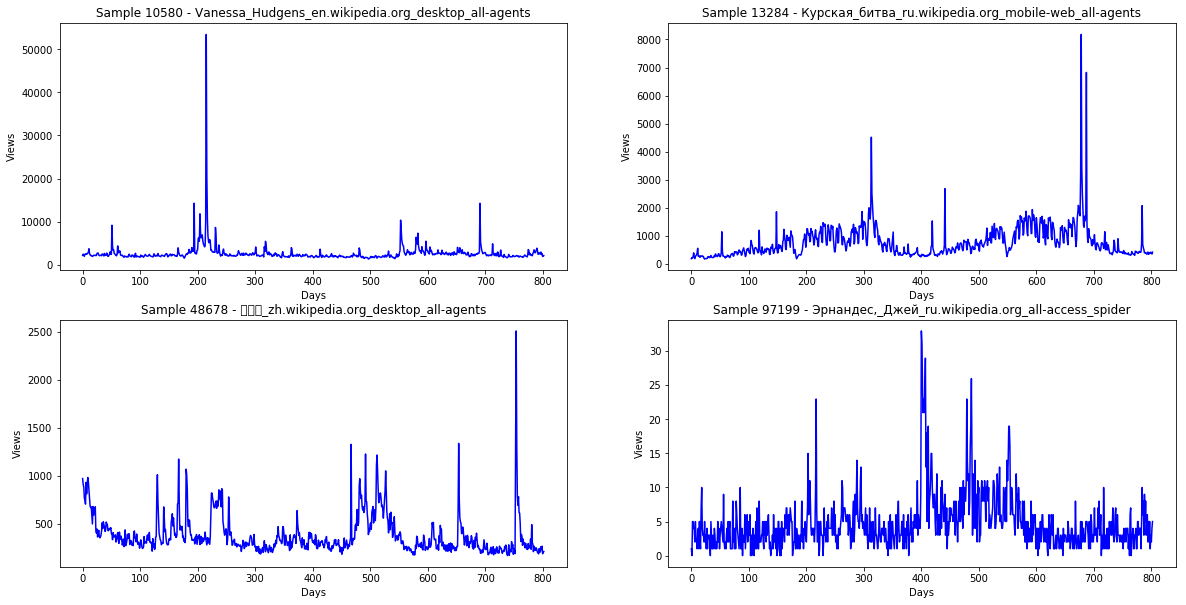

In [175]:
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    sample = random.randint(0,original_dataset.shape[0])
    data = original_dataset.iloc[sample,1:]
    plot_series(data,f"Sample {sample} - {original_dataset.iloc[sample,0]}",new_plot=False,plot_show=False)
plt.show()

## Extracting metadata

Here, we take the compound page name and extract the name of the article, the language, the type of access and the agent for each page.

In [176]:
def extract_meta(page):
    parts = page.split("_")
    [project,access,agent] = parts[-3:]
    name = " ".join(parts[0:-3])
    match_lang = re.search("([a-z][a-z])\.wikipedia\.org",project)
    lang = match_lang.group(1) if match_lang else 'na'
    return [name,lang,access,agent]

In [177]:
meta_dataset = original_dataset.copy()
meta_dataset['name'],  meta_dataset['lang'], meta_dataset['access'], meta_dataset['agent'] = zip(*meta_dataset['Page'].apply(extract_meta))
meta_dataset = meta_dataset[['name', 'lang', 'access', 'agent'] + [c for c in meta_dataset if c not in ['Page', 'name', 'lang', 'access', 'agent']]]

In [178]:
meta_dataset.head()

name lang      access   agent  2015-07-01  2015-07-02  2015-07-03  \
0     2NE1   zh  all-access  spider        18.0        11.0         5.0   
1      2PM   zh  all-access  spider        11.0        14.0        15.0   
2       3C   zh  all-access  spider         1.0         0.0         1.0   
3  4minute   zh  all-access  spider        35.0        13.0        10.0   
4     5566   zh  all-access  spider        12.0         7.0         4.0   

   2015-07-04  2015-07-05  2015-07-06     ...      2017-09-01  2017-09-02  \
0        13.0        14.0         9.0     ...            19.0        33.0   
1        18.0        11.0        13.0     ...            32.0        30.0   
2         1.0         0.0         4.0     ...             6.0         6.0   
3        94.0         4.0        26.0     ...             7.0        19.0   
4         5.0        20.0         8.0     ...            13.0        13.0   

   2017-09-03  2017-09-04  2017-09-05  2017-09-06  2017-09-07  2017-09-08  \
0        33.0        18.0        16.0        27.0        29.0        23.0   
1        11.0        19.0        54.0        25.0        26.0        23.0   
2         7.0         2.0         4.0         7.0         3.0         4.0   
3        19.0         9.0         6.0        16.0        19.0        30.0   
4        45.0         4.0        13.0        20.0        18.0        17.0   

   2017-09-09  2017-09-10  
0        54.0        38.0  
1        13.0        81.0  
2         7.0         6.0  
3        38.0         4.0  
4        14.0        11.0  

[5 rows x 807 columns]

In [179]:
ordinal_encoder = OrdinalEncoder()
meta_dataset.iloc[:,:4] = ordinal_encoder.fit_transform(meta_dataset.iloc[:,:4])

In [180]:
meta_dataset.head()

name  lang  access  agent  2015-07-01  2015-07-02  2015-07-03  2015-07-04  \
0  588.0   7.0     0.0    1.0        18.0        11.0         5.0        13.0   
1  589.0   7.0     0.0    1.0        11.0        14.0        15.0        18.0   
2  643.0   7.0     0.0    1.0         1.0         0.0         1.0         1.0   
3  683.0   7.0     0.0    1.0        35.0        13.0        10.0        94.0   
4  699.0   7.0     0.0    1.0        12.0         7.0         4.0         5.0   

   2015-07-05  2015-07-06     ...      2017-09-01  2017-09-02  2017-09-03  \
0        14.0         9.0     ...            19.0        33.0        33.0   
1        11.0        13.0     ...            32.0        30.0        11.0   
2         0.0         4.0     ...             6.0         6.0         7.0   
3         4.0        26.0     ...             7.0        19.0        19.0   
4        20.0         8.0     ...            13.0        13.0        45.0   

   2017-09-04  2017-09-05  2017-09-06  2017-09-07  2017-09-08  2017-09-09  \
0        18.0        16.0        27.0        29.0        23.0        54.0   
1        19.0        54.0        25.0        26.0        23.0        13.0   
2         2.0         4.0         7.0         3.0         4.0         7.0   
3         9.0         6.0        16.0        19.0        30.0        38.0   
4         4.0        13.0        20.0        18.0        17.0        14.0   

   2017-09-10  
0        38.0  
1        81.0  
2         6.0  
3         4.0  
4        11.0  

[5 rows x 807 columns]

In [181]:
ordinal_encoder.categories_

[array(['"Weird Al" Yankovic', "'Tis the Season",
        "'Tis the Season (Vince Gill and Olivia Newton-John album)", ...,
        '龙生九子', '대문', '［Alexandros］'], dtype=object),
 array(['de', 'en', 'es', 'fr', 'ja', 'na', 'ru', 'zh'], dtype=object),
 array(['all-access', 'desktop', 'mobile-web'], dtype=object),
 array(['all-agents', 'spider'], dtype=object)]

## Splitting data

In [131]:
training_days = 365+366
features_dataset = meta_dataset.iloc[:,4:]
meta_dataset = meta_dataset.iloc[:,:4]
train_dataset = features_dataset.iloc[:,:training_days]
test_dataset = features_dataset.iloc[:,training_days:]

In [132]:
meta_dataset.head()

name  lang  access  agent
0  588.0   7.0     0.0    1.0
1  589.0   7.0     0.0    1.0
2  643.0   7.0     0.0    1.0
3  683.0   7.0     0.0    1.0
4  699.0   7.0     0.0    1.0

In [133]:
train_dataset.head()

2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  \
0        18.0        11.0         5.0        13.0        14.0         9.0   
1        11.0        14.0        15.0        18.0        11.0        13.0   
2         1.0         0.0         1.0         1.0         0.0         4.0   
3        35.0        13.0        10.0        94.0         4.0        26.0   
4        12.0         7.0         4.0         5.0        20.0         8.0   

   2015-07-07  2015-07-08  2015-07-09  2015-07-10     ...      2017-06-21  \
0         9.0        22.0        26.0        24.0     ...            28.0   
1        22.0        11.0        10.0         4.0     ...            17.0   
2         0.0         3.0         4.0         4.0     ...             8.0   
3        14.0         9.0        11.0        16.0     ...            12.0   
4         5.0        17.0        24.0         7.0     ...            16.0   

   2017-06-22  2017-06-23  2017-06-24  2017-06-25  2017-06-26  2017-06-27  \
0        26.0        29.0        21.0        23.0        23.0        32.0   
1        24.0        18.0       193.0        26.0        62.0       127.0   
2         7.0         3.0         5.0         4.0         4.0         5.0   
3        17.0        15.0        12.0        11.0        12.0        10.0   
4        10.0        17.0        19.0        20.0        30.0        13.0   

   2017-06-28  2017-06-29  2017-06-30  
0        34.0        21.0        24.0  
1       104.0        20.0        29.0  
2         5.0         0.0         6.0  
3        22.0        21.0        30.0  
4        14.0        14.0        20.0  

[5 rows x 731 columns]

In [134]:
test_dataset.head()

2017-07-01  2017-07-02  2017-07-03  2017-07-04  2017-07-05  2017-07-06  \
0        23.0        24.0        26.0        15.0        14.0        15.0   
1        15.0        26.0        16.0        23.0        19.0        16.0   
2         1.0         1.0         7.0         1.0         1.0         1.0   
3         7.0        19.0        16.0        10.0        17.0        15.0   
4        10.0        10.0        29.0        33.0        20.0        22.0   

   2017-07-07  2017-07-08  2017-07-09  2017-07-10     ...      2017-09-01  \
0        19.0        29.0        22.0        25.0     ...            19.0   
1       816.0        20.0        76.0        24.0     ...            32.0   
2        10.0         1.0         2.0         6.0     ...             6.0   
3        22.0         6.0         6.0        18.0     ...             7.0   
4        12.0        76.0        19.0        23.0     ...            13.0   

   2017-09-02  2017-09-03  2017-09-04  2017-09-05  2017-09-06  2017-09-07  \
0        33.0        33.0        18.0        16.0        27.0        29.0   
1        30.0        11.0        19.0        54.0        25.0        26.0   
2         6.0         7.0         2.0         4.0         7.0         3.0   
3        19.0        19.0         9.0         6.0        16.0        19.0   
4        13.0        45.0         4.0        13.0        20.0        18.0   

   2017-09-08  2017-09-09  2017-09-10  
0        23.0        54.0        38.0  
1        23.0        13.0        81.0  
2         4.0         7.0         6.0  
3        30.0        38.0         4.0  
4        17.0        14.0        11.0  

[5 rows x 72 columns]

## Clustering time series

In [135]:
min_max_scaler = preprocessing.MinMaxScaler()

train_dataset_norm = pd.DataFrame(min_max_scaler.fit_transform(train_dataset.transpose()).transpose(),columns=train_dataset.columns)

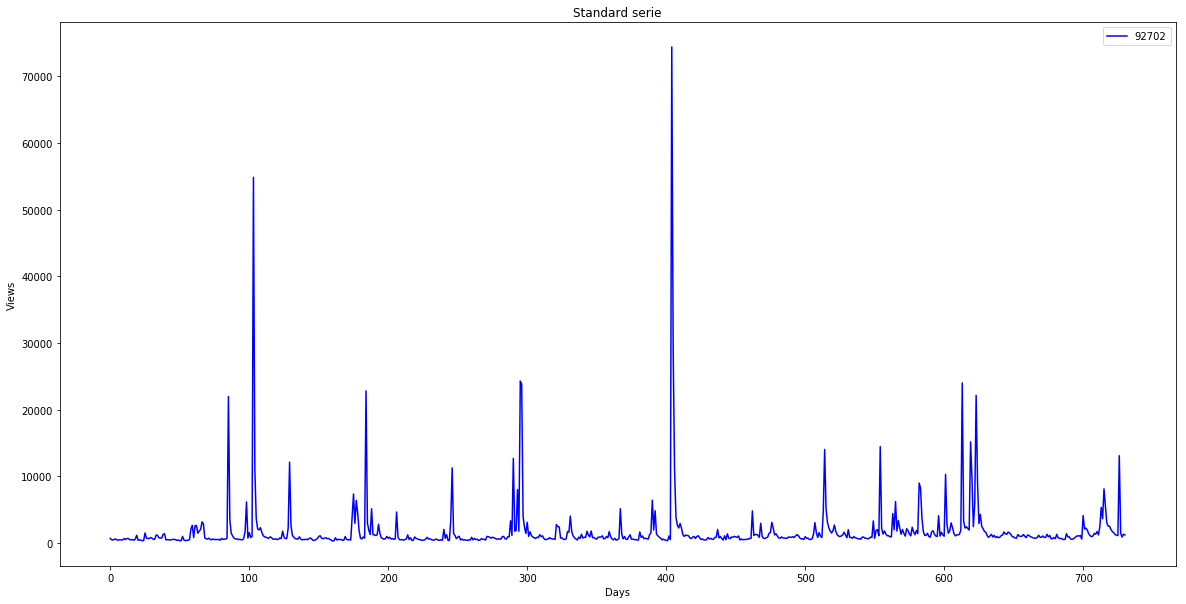

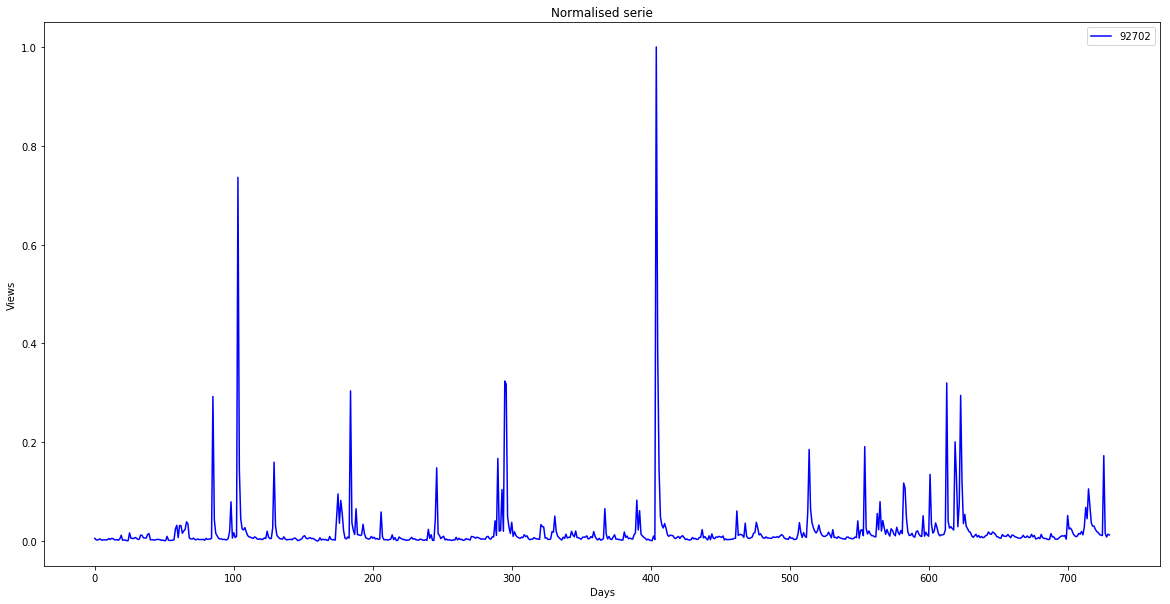

In [136]:
sample = random.randint(0,len(train_dataset))
plot_series(train_dataset.iloc[sample,:],"Standard serie")
plot_series(train_dataset_norm.iloc[sample,:],"Normalised serie")

In [137]:
std = train_dataset_norm.std(axis=1)
std

0         0.055815
1         0.050798
2         0.056325
3         0.058371
4         0.073302
5         0.094356
6         0.082702
7         0.121844
8         0.094849
9         0.118781
10        0.064783
11        0.081952
12        0.105794
13        0.048867
14        0.084055
15        0.085338
16        0.053496
17        0.097299
18        0.054140
19        0.102865
20        0.096192
21        0.062814
22        0.083086
23        0.079708
24        0.075415
25        0.067034
26        0.079173
27        0.070854
28        0.053776
29        0.044170
            ...   
115054    0.047312
115055    0.084404
115056    0.075208
115057    0.106792
115058    0.100702
115059    0.065807
115060    0.081040
115061    0.088236
115062    0.091303
115063    0.066858
115064    0.092446
115065    0.094111
115066    0.100656
115067    0.121556
115068    0.066023
115069    0.051414
115070    0.089088
115071    0.081974
115072    0.108384
115073    0.106057
115074    0.083051
115075    0.

In [138]:
buckets_std = pd.qcut(x=std,q=10,labels=False)
buckets_std

0         3
1         2
2         3
3         4
4         5
5         7
6         6
7         8
8         7
9         8
10        4
11        6
12        8
13        2
14        6
15        6
16        3
17        7
18        3
19        8
20        7
21        4
22        6
23        6
24        6
25        5
26        6
27        5
28        3
29        1
         ..
115054    2
115055    6
115056    6
115057    8
115058    7
115059    5
115060    6
115061    7
115062    7
115063    5
115064    7
115065    7
115066    7
115067    8
115068    5
115069    2
115070    7
115071    6
115072    8
115073    8
115074    6
115075    8
115076    6
115077    1
115078    0
115079    4
115080    7
115081    7
115082    7
115083    7
Length: 115084, dtype: int64

0


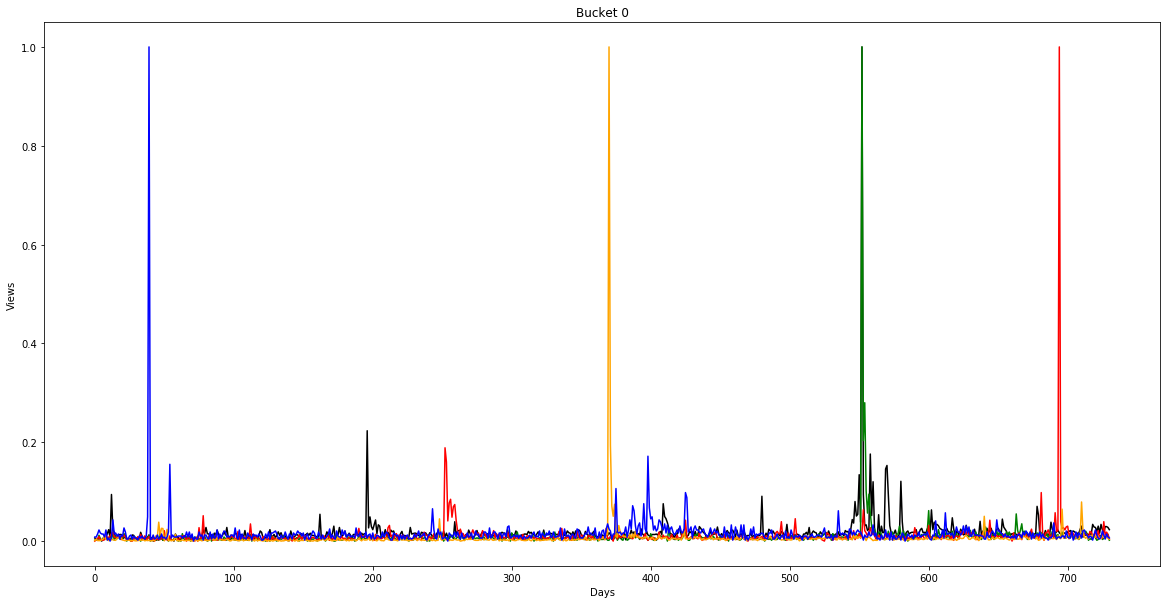

1


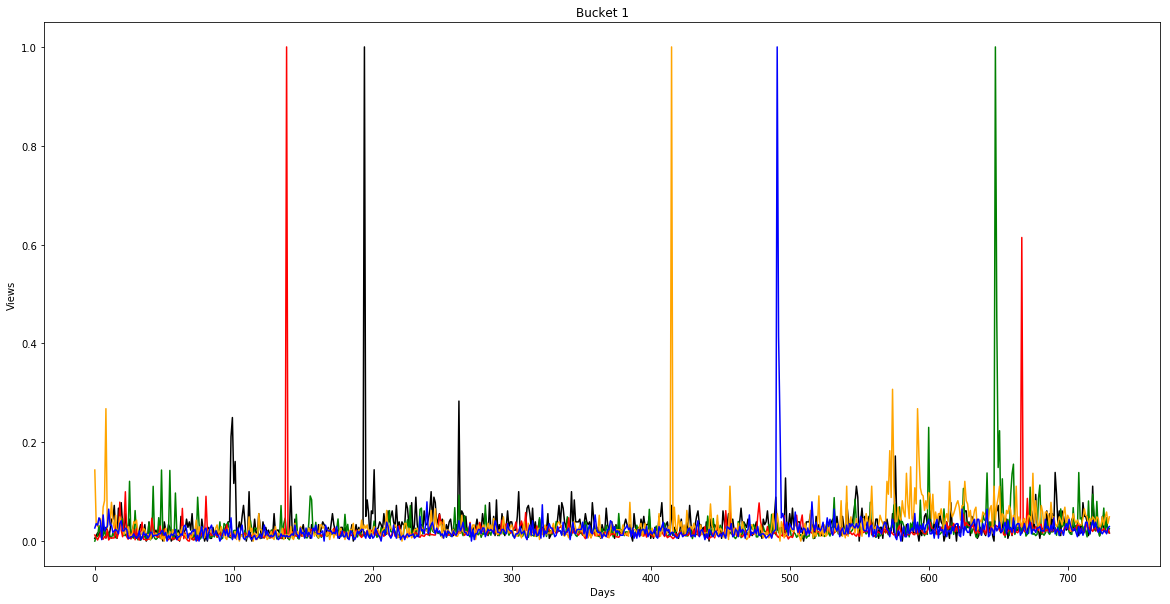

2


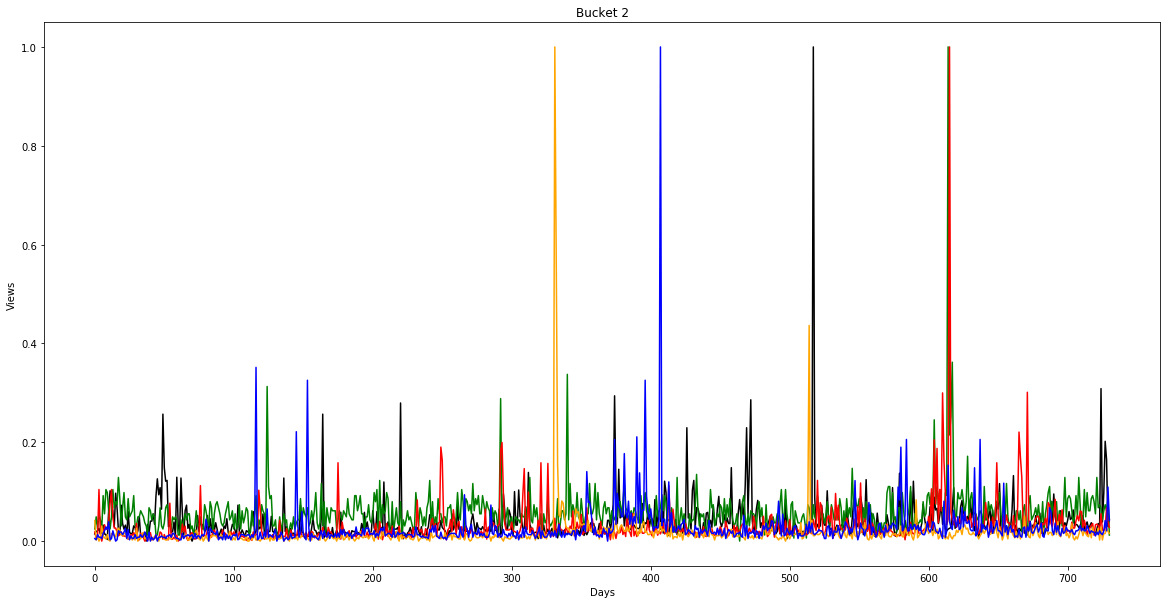

3


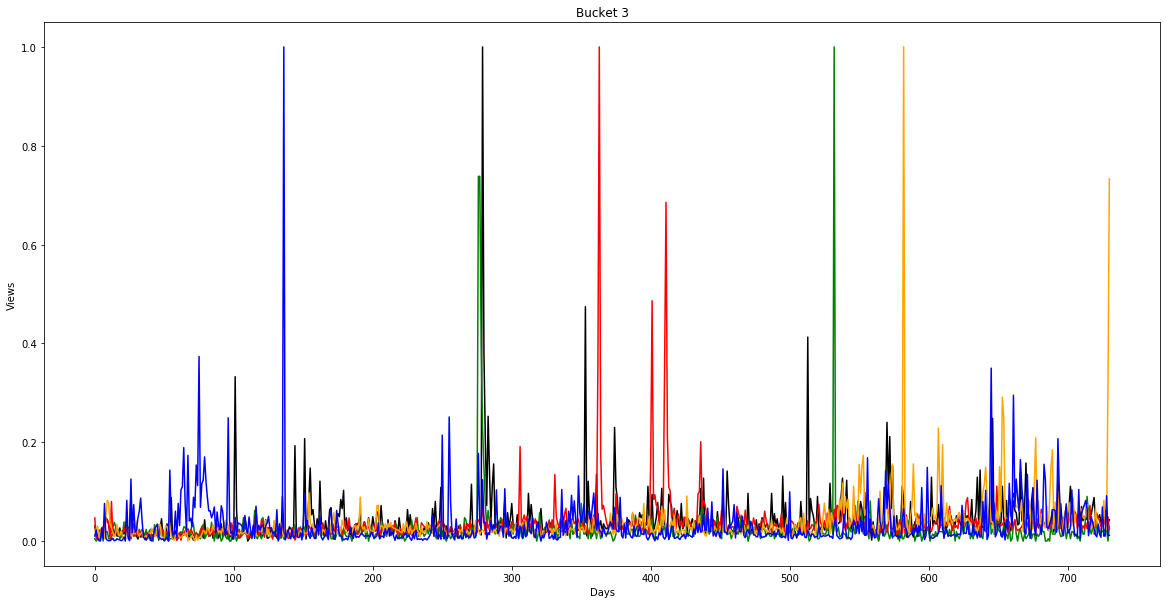

4


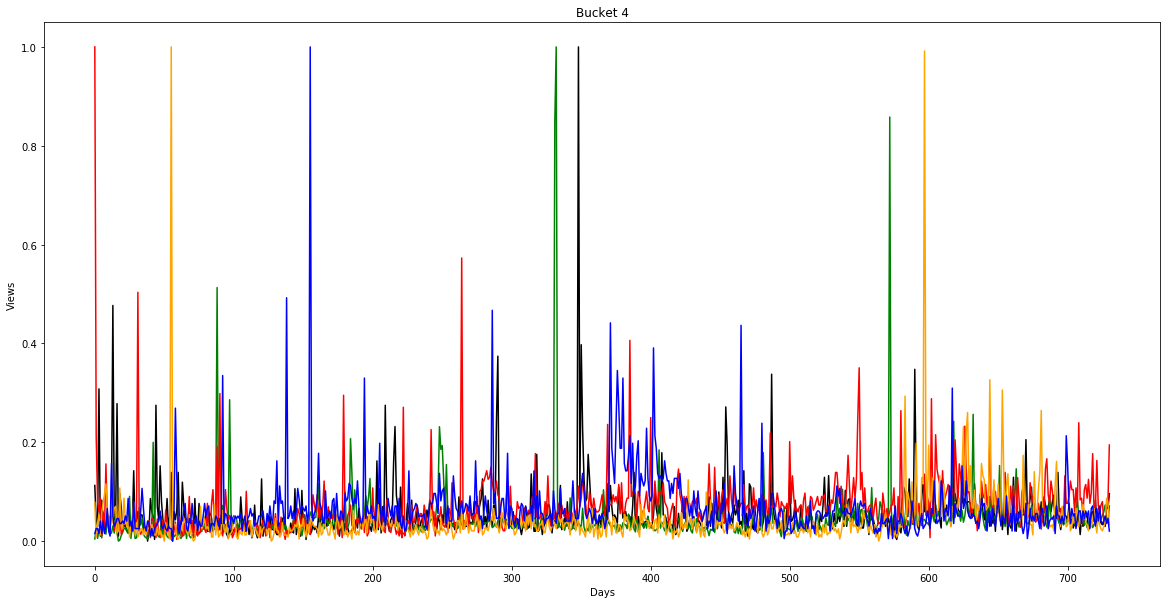

5


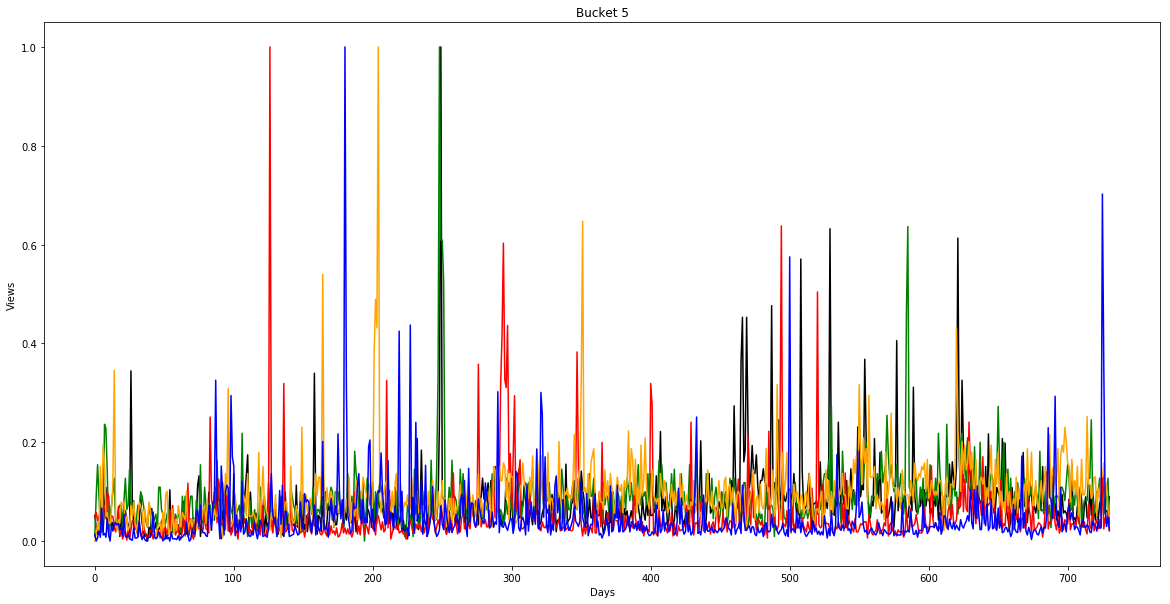

6


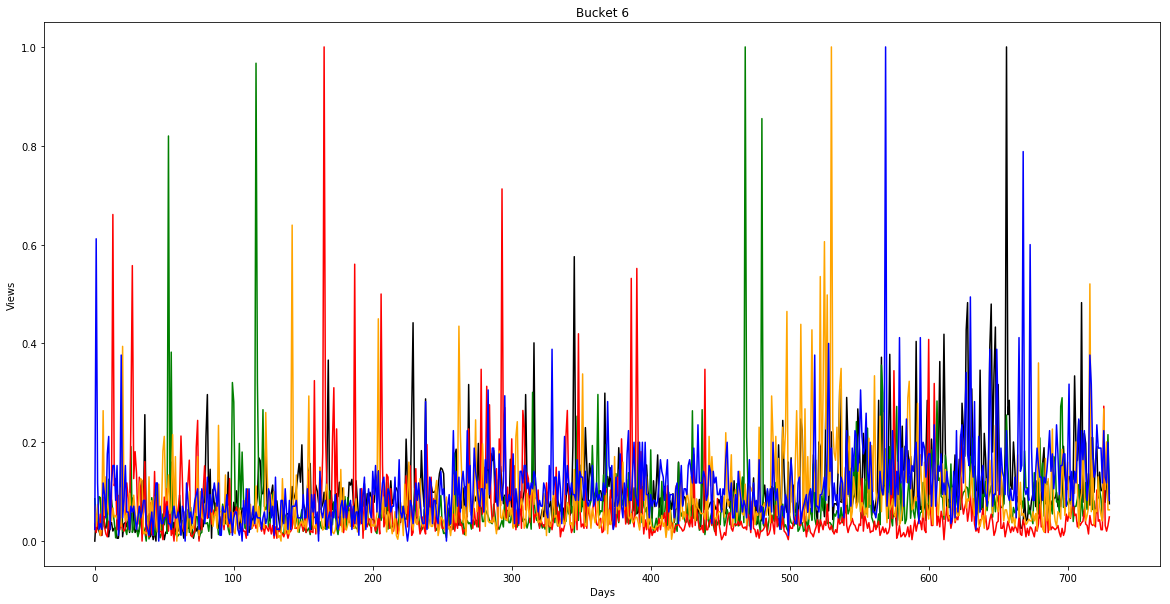

7


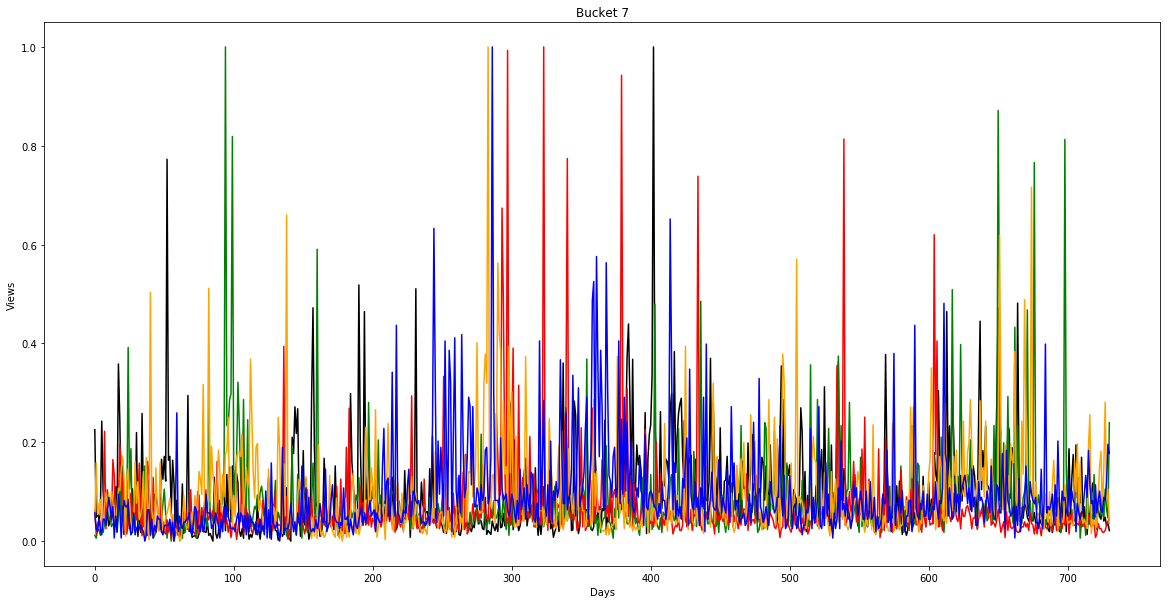

8


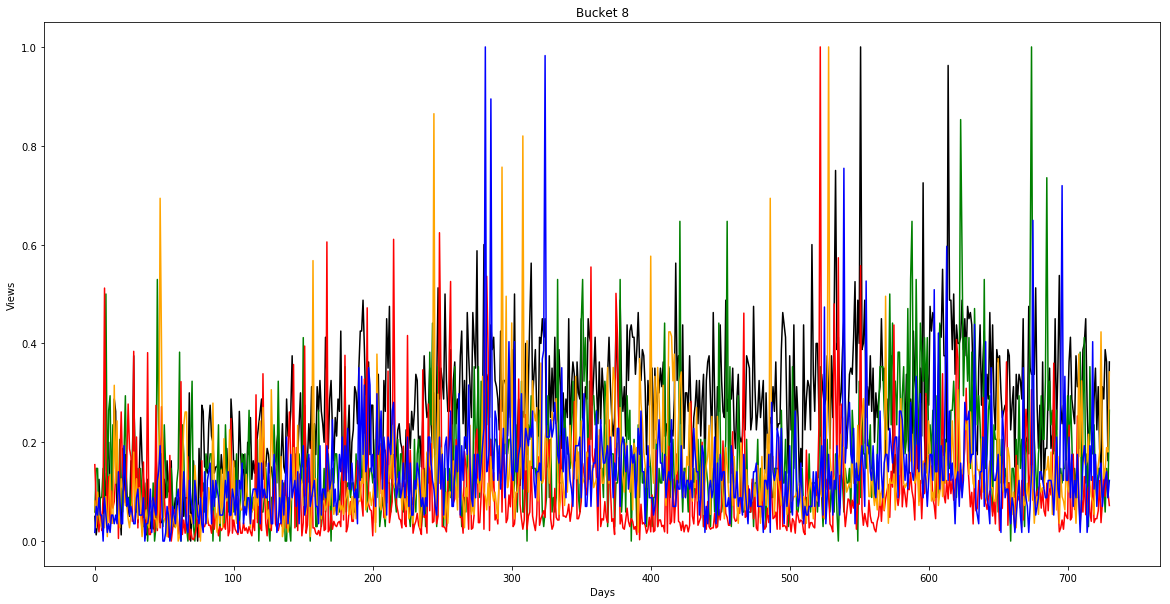

9


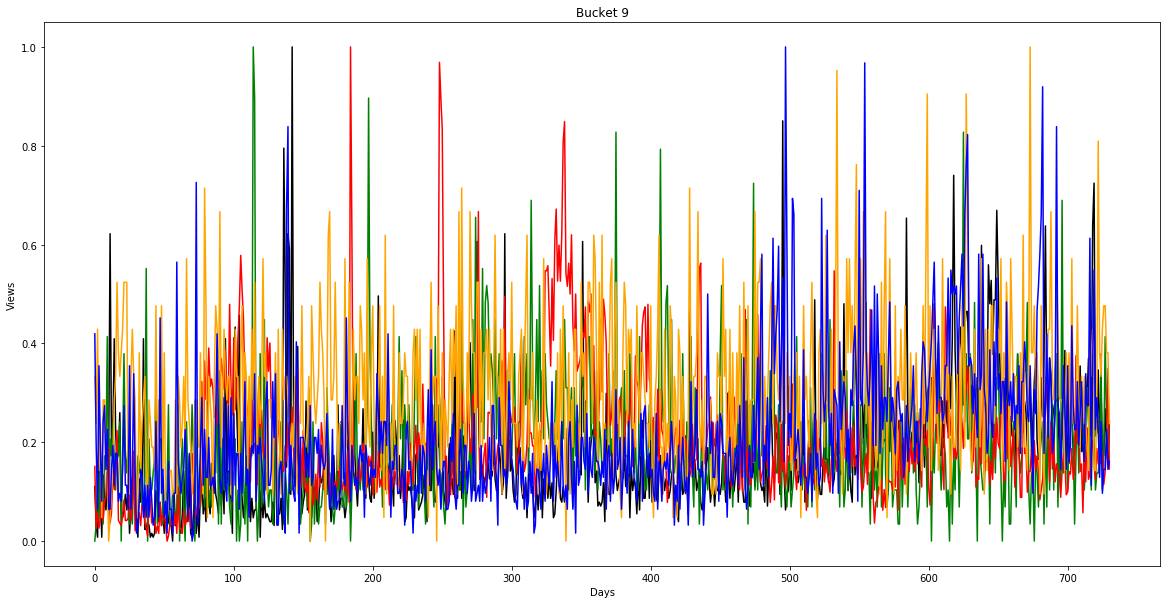

In [139]:
colors = ['black','green','red','orange','blue']
for buck in range(10):
    print(buck)
    filtered = train_dataset_norm[buckets_std == buck]
    plt.figure(figsize=(20,10))
    for sample in range(5):
        plot_series(filtered.iloc[sample,:],f"Bucket {buck}",new_plot=False,plot_show=False,color=colors[sample])
    plt.show()

In [140]:
rest_training,dtw_training,rest_buckets, dtw_buckets = train_test_split(train_dataset_norm,buckets_std,test_size=0.01,random_state=42,stratify=buckets_std)
dtw_training.info()
dtw_training.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151 entries, 1034 to 26044
Columns: 731 entries, 2015-07-01 to 2017-06-30
dtypes: float64(731)
memory usage: 6.4 MB


2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  \
1034      0.241164    0.322245    0.266112    0.103950    0.567568   
106532    0.000368    0.001103    0.000735    0.000735    0.000000   
17845     0.024344    0.075364    0.032502    0.015798    0.010554   
39872     0.000251    0.001656    0.000803    0.001305    0.001455   
60784     0.065753    0.031507    0.061644    0.060274    0.063014   

        2015-07-06  2015-07-07  2015-07-08  2015-07-09  2015-07-10  \
1034      0.442827    0.220374    0.149688    0.544699    0.191268   
106532    0.000735    0.000735    0.001103    0.002206    0.001103   
17845     0.015151    0.022920    0.012625    0.026416    0.015992   
39872     0.000953    0.000050    0.001054    0.000452    0.000151   
60784     0.054795    0.100000    0.026027    0.104110    0.027397   

           ...      2017-06-21  2017-06-22  2017-06-23  2017-06-24  \
1034       ...        0.033264    0.047817    0.074844    0.072765   
106532     ...        0.004412    0.008088    0.012500    0.018015   
17845      ...        0.010036    0.006216    0.006928    0.003626   
39872      ...        0.001003    0.000552    0.001204    0.001806   
60784      ...        0.384932    0.315068    0.275342    0.483562   

        2017-06-25  2017-06-26  2017-06-27  2017-06-28  2017-06-29  2017-06-30  
1034      0.047817    0.027027    0.029106    0.043659    0.045738    0.027027  
106532    0.009926    0.043382    0.004779    0.005515    0.004779    0.003676  
17845     0.003043    0.004467    0.006539    0.003432    0.003173    0.001165  
39872     0.002408    0.000903    0.001656    0.001756    0.001806    0.001505  
60784     0.509589    0.387671    0.402740    0.404110    0.331507    0.401370  

[5 rows x 731 columns]

In [141]:
buckets_unique = dtw_buckets.unique()
buckets_unique.sort()
for i in buckets_unique:
    print(f"{i} => {len(dtw_buckets[dtw_buckets == i])}")

0 => 116
1 => 115
2 => 115
3 => 115
4 => 115
5 => 115
6 => 115
7 => 115
8 => 115
9 => 115


In [142]:
dtw_training_np = dtw_training.values.astype(np.float) 
ds = dtw.distance_matrix_fast(dtw_training_np, show_progress=True)

INFO:be.kuleuven.dtai.distance:Computing distances
INFO:be.kuleuven.dtai.distance:Compute distances in pure C (parallel=True)


In [143]:
for i in range(ds.shape[0]):
    for j in range(i, ds.shape[1]):
        if i == j: 
            ds[i][i] = 0
        elif i < j:
            ds[j][i] = ds[i][j]

In [144]:
print(ds)

[[0.         1.89067557 1.7608978  ... 2.1136989  1.8916372  2.24111152]
 [1.89067557 0.         0.81577345 ... 0.96242728 1.38009863 0.8918    ]
 [1.7608978  0.81577345 0.         ... 1.04931952 1.0592973  1.0102026 ]
 ...
 [2.1136989  0.96242728 1.04931952 ... 0.         1.17165996 0.99216595]
 [1.8916372  1.38009863 1.0592973  ... 1.17165996 0.         1.87810003]
 [2.24111152 0.8918     1.0102026  ... 0.99216595 1.87810003 0.        ]]


In [145]:
clustering = AgglomerativeClustering(n_clusters=10, affinity='euclidean', connectivity=ds, compute_full_tree=True, linkage='ward')
clustering.fit(ds)
clustering.labels_

array([3, 9, 9, ..., 9, 0, 4])

0 => 267


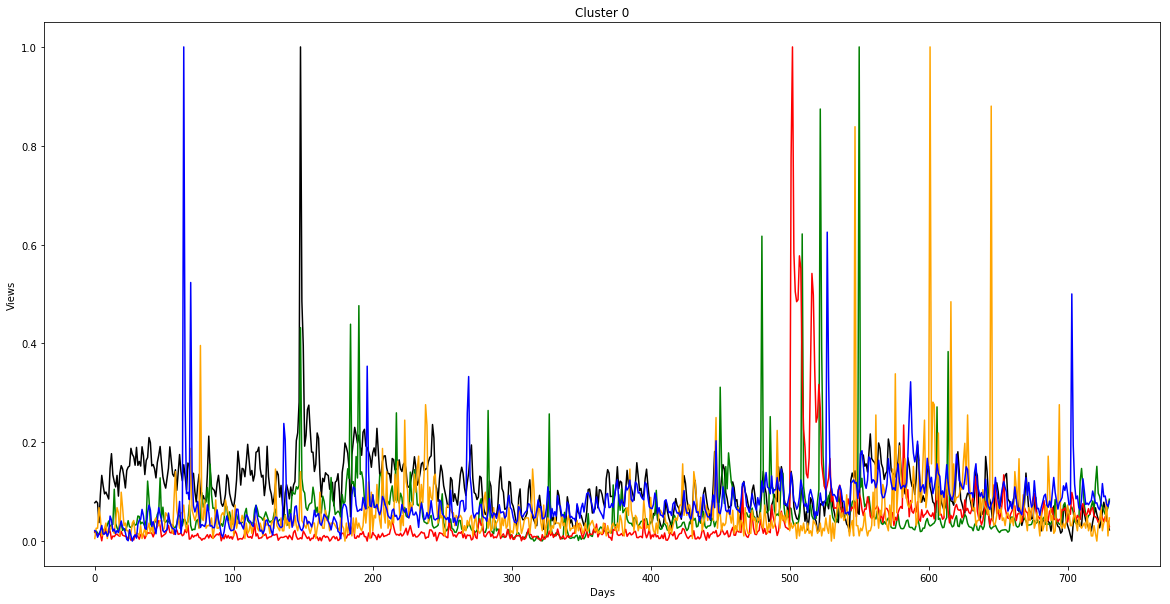

1 => 22


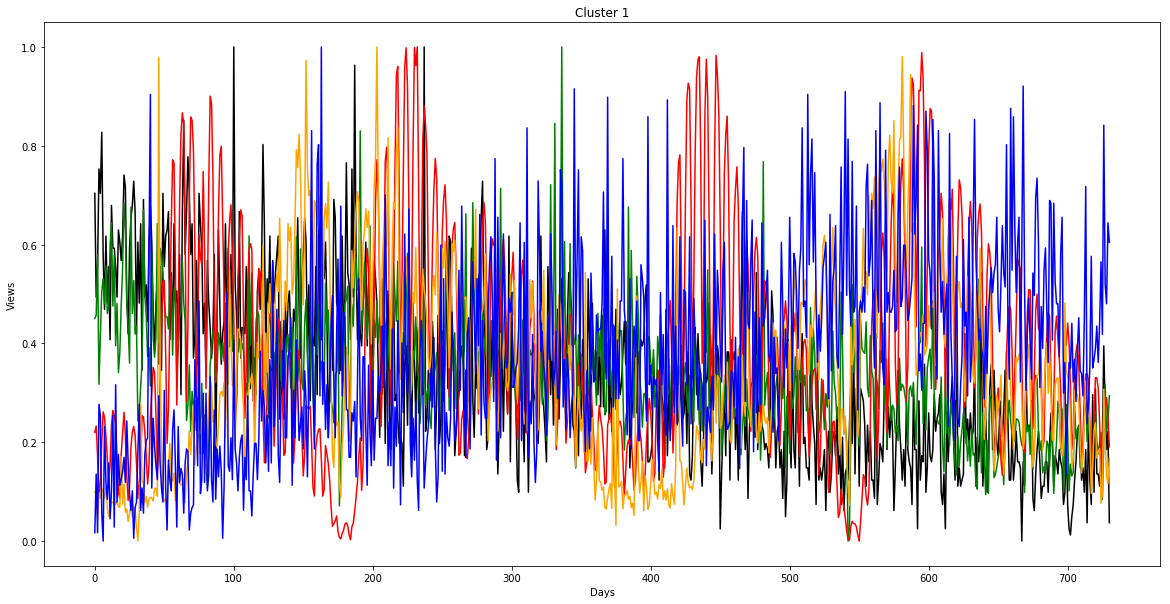

2 => 223


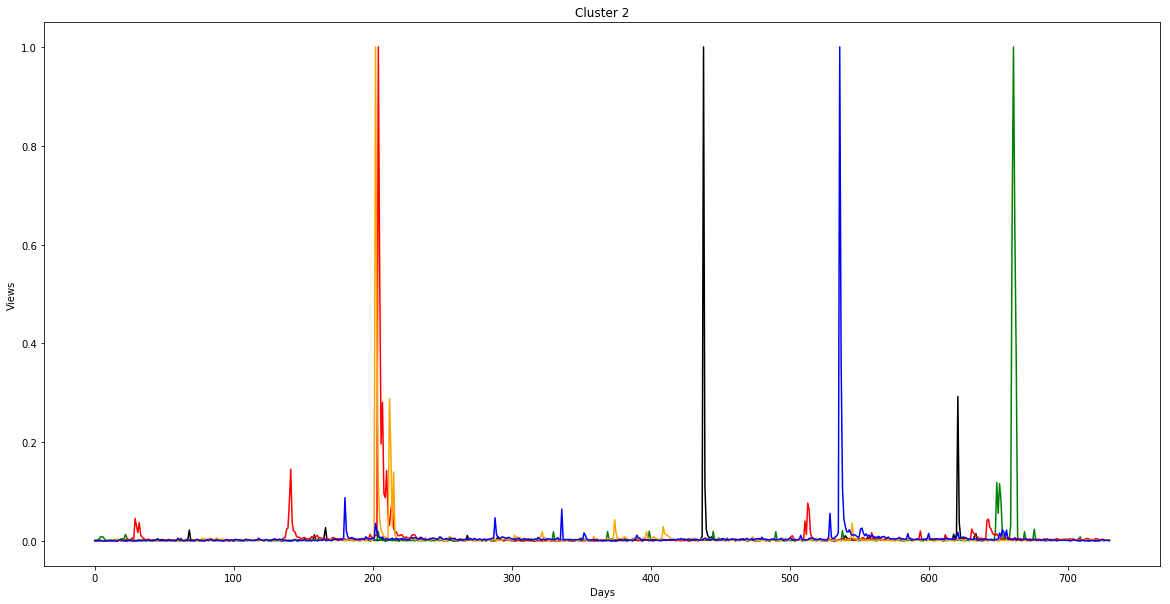

3 => 134


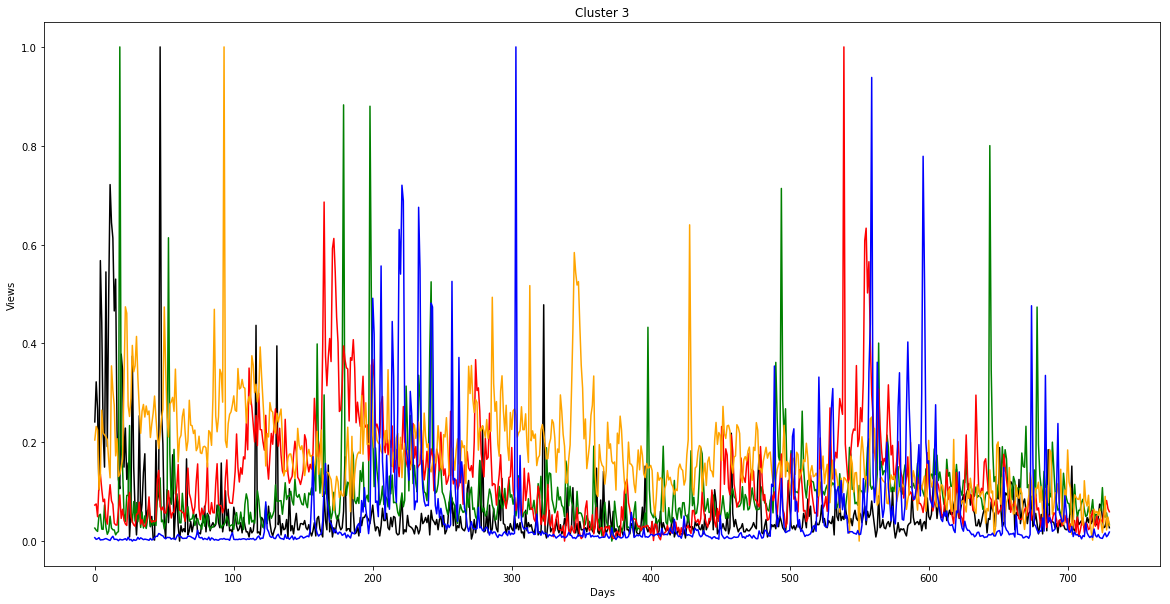

4 => 54


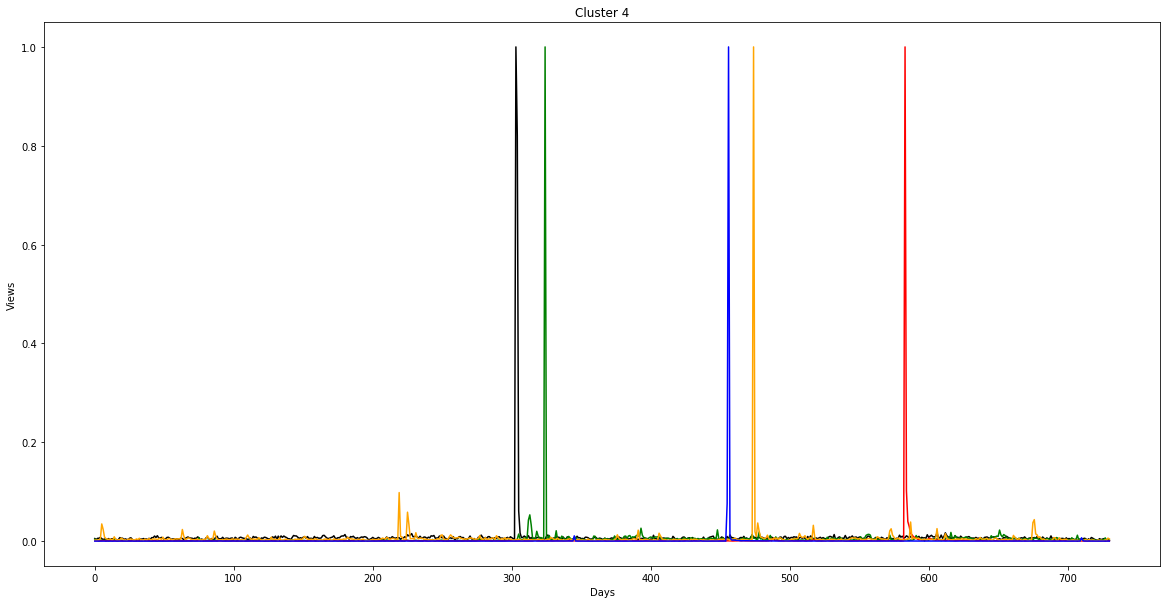

5 => 76


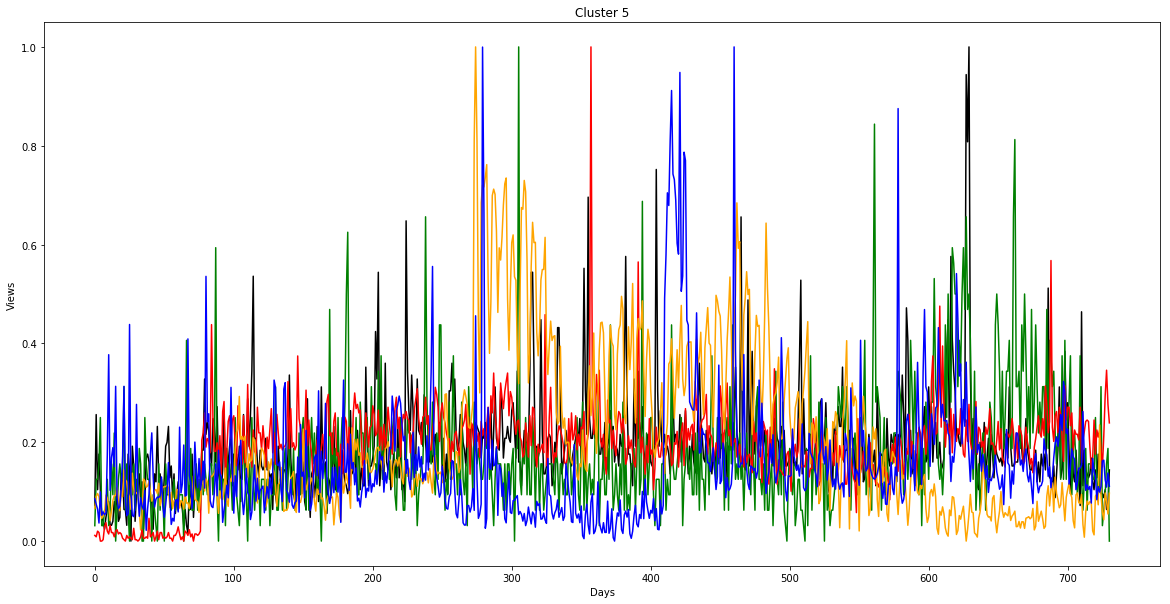

6 => 34


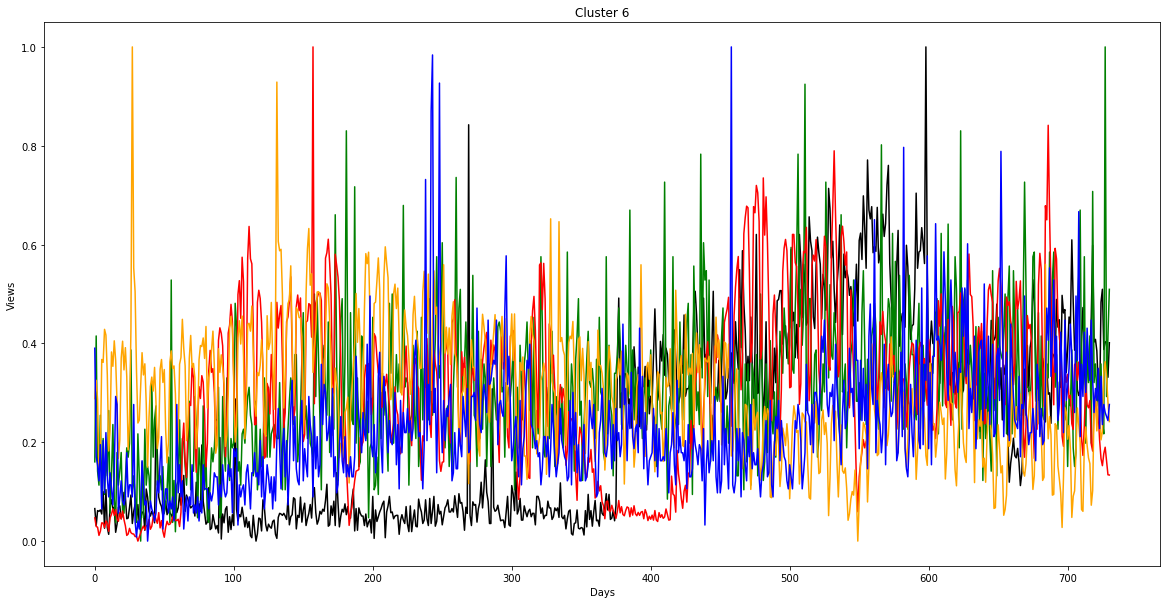

7 => 7


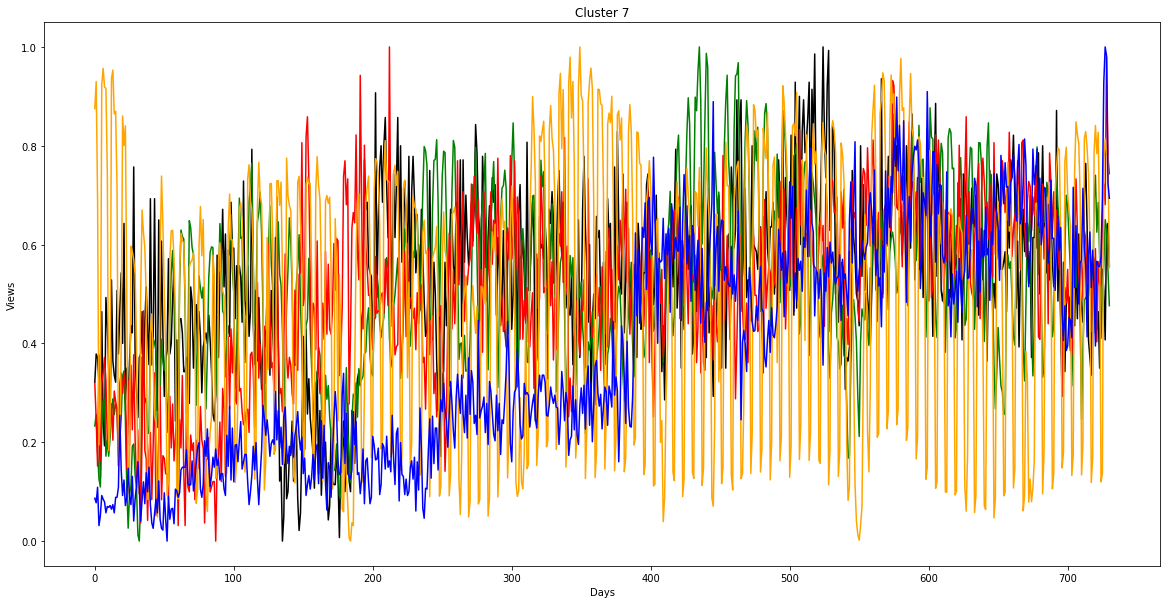

8 => 124


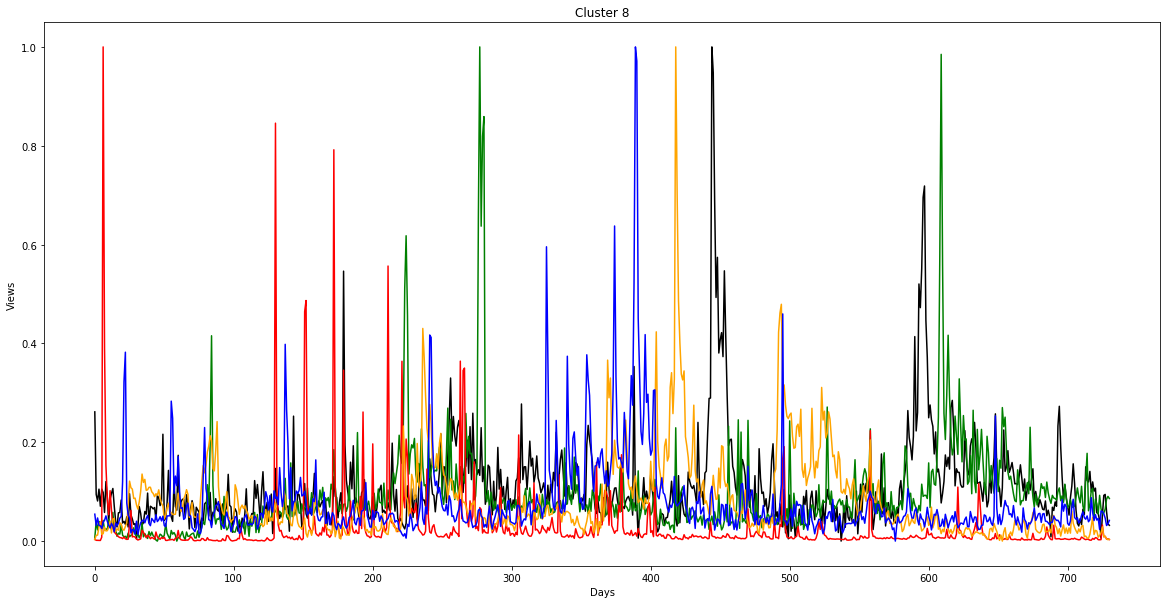

9 => 210


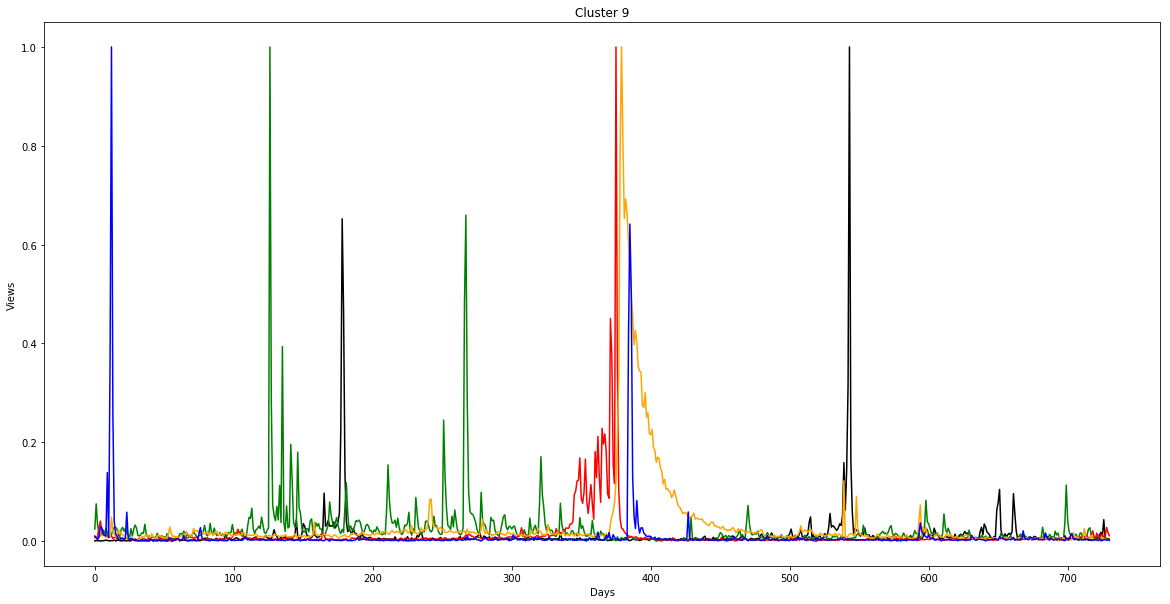

In [146]:
labels = clustering.labels_
labels_unique = np.unique(labels)
for i in labels_unique:
    count = len(labels[labels == i])
    print(f"{i} => {count}")
    plt.figure(figsize=(20,10))
    filtered = dtw_training[labels == i]
    for sample in range(min(count,5)):
        plot_series(filtered.iloc[sample,:],f"Cluster {i}",new_plot=False,plot_show=False,color=colors[sample])
    plt.show()

In [147]:
knn = KNN(n_neighbors=1)

knn.fit(dtw_training,labels)
labels_rest = knn.predict(rest_training)

0 => 20445


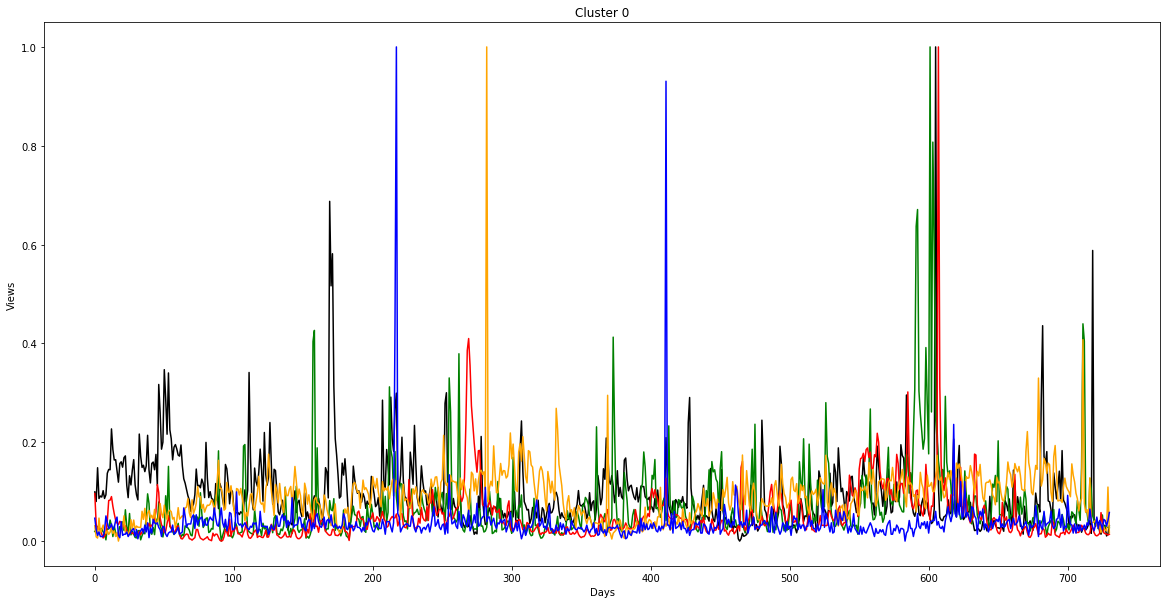

1 => 1976


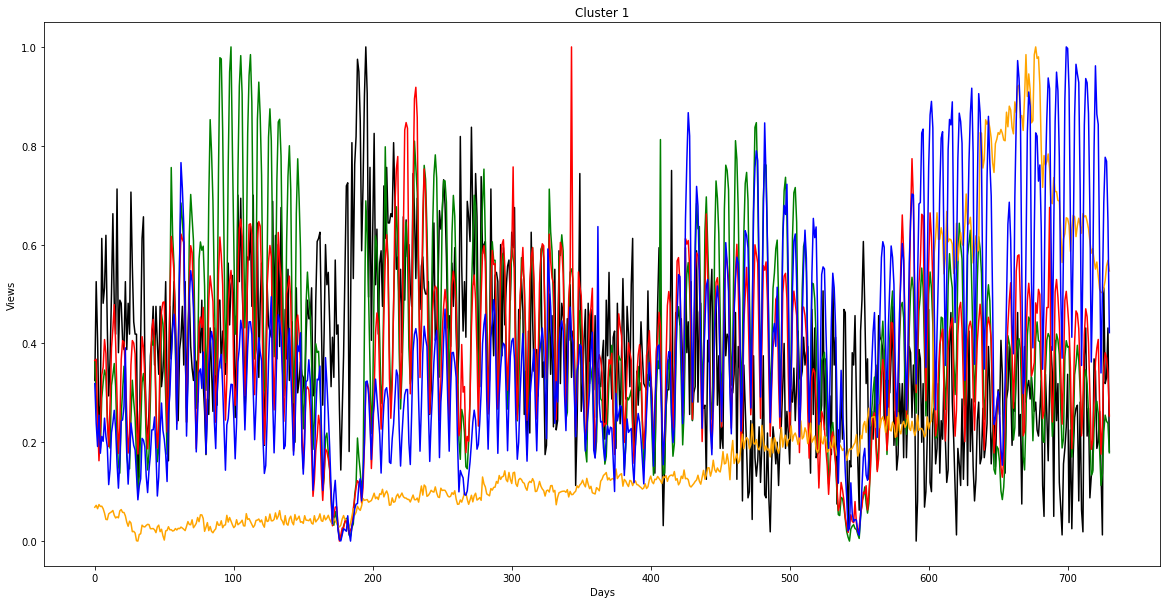

2 => 34873


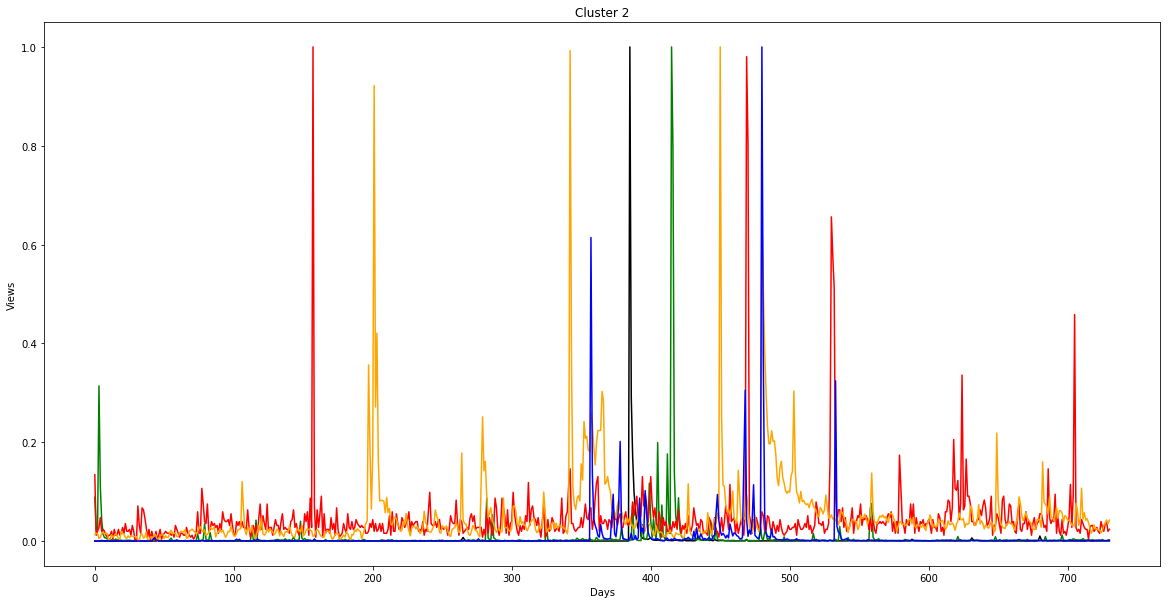

3 => 7370


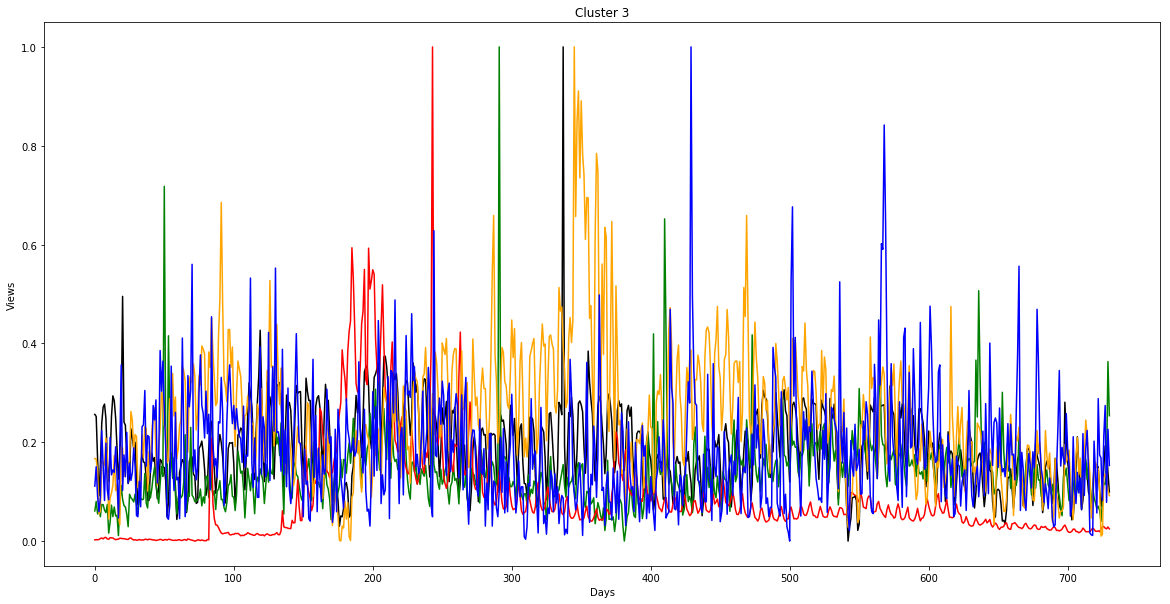

4 => 8933


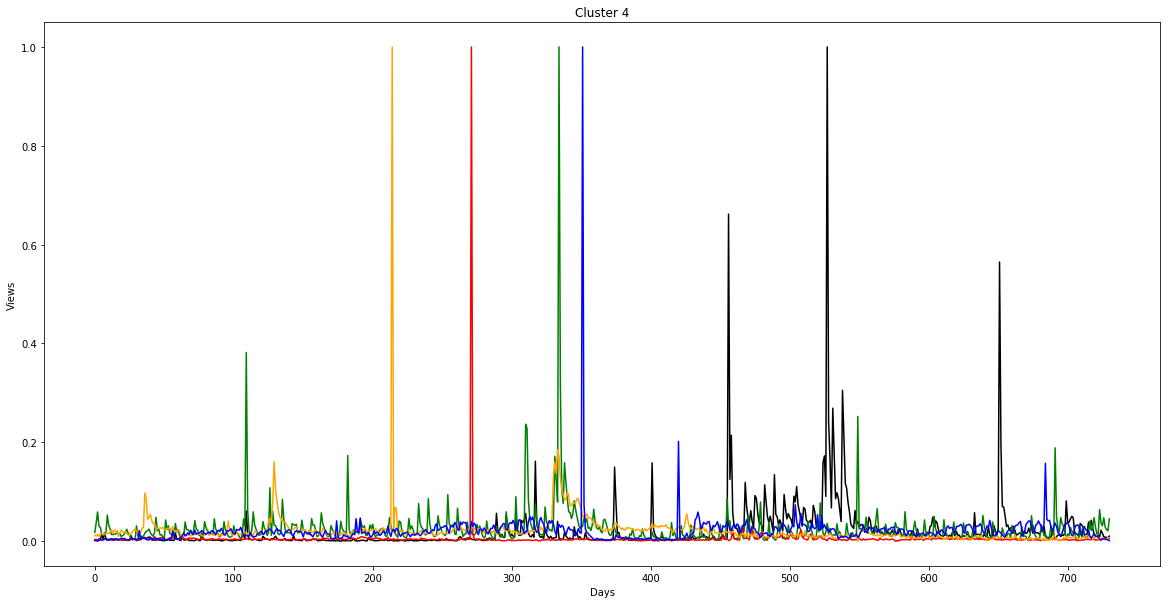

5 => 6264


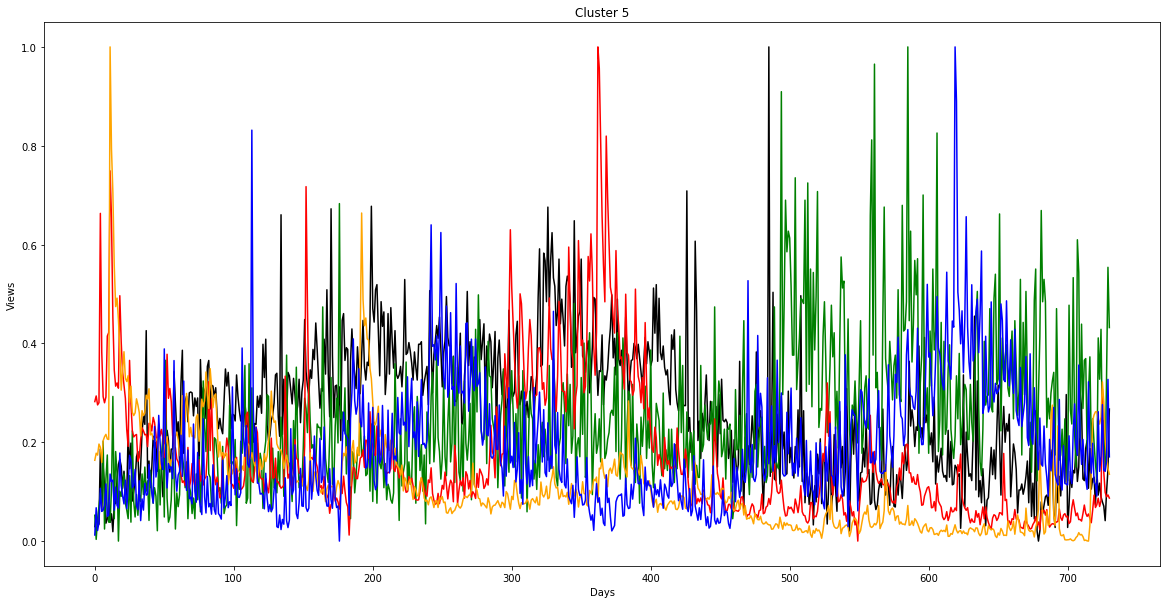

6 => 2014


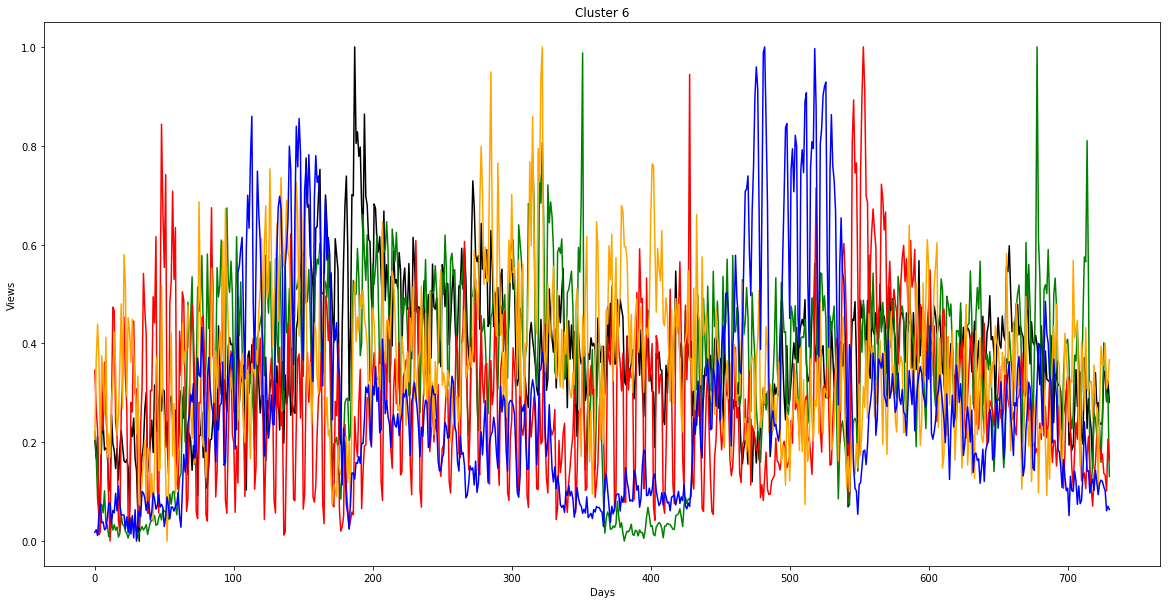

7 => 523


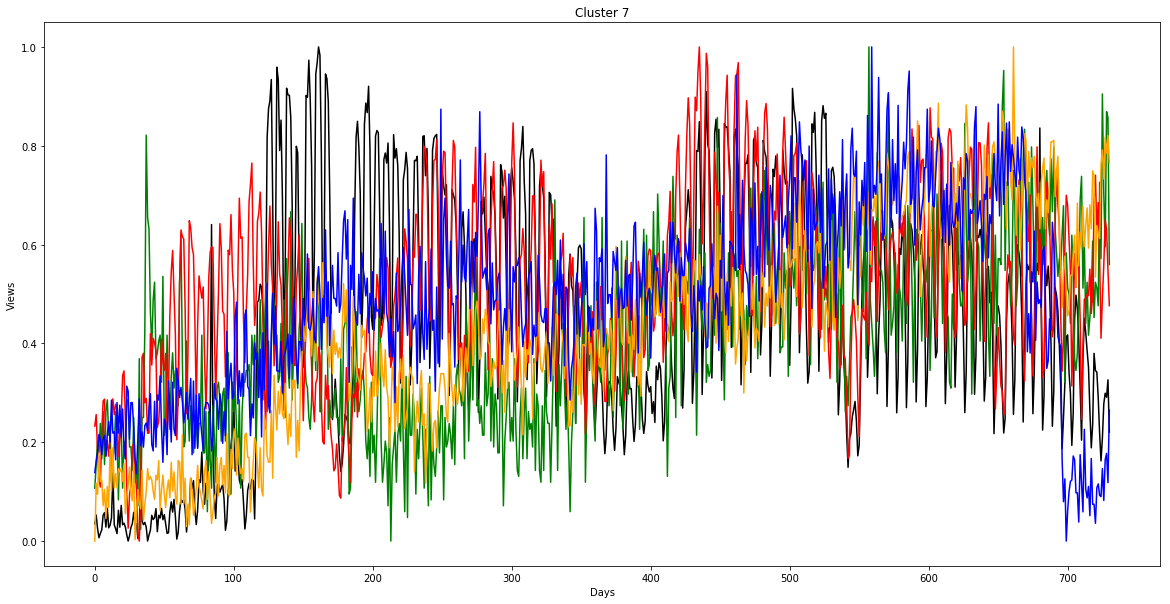

8 => 7117


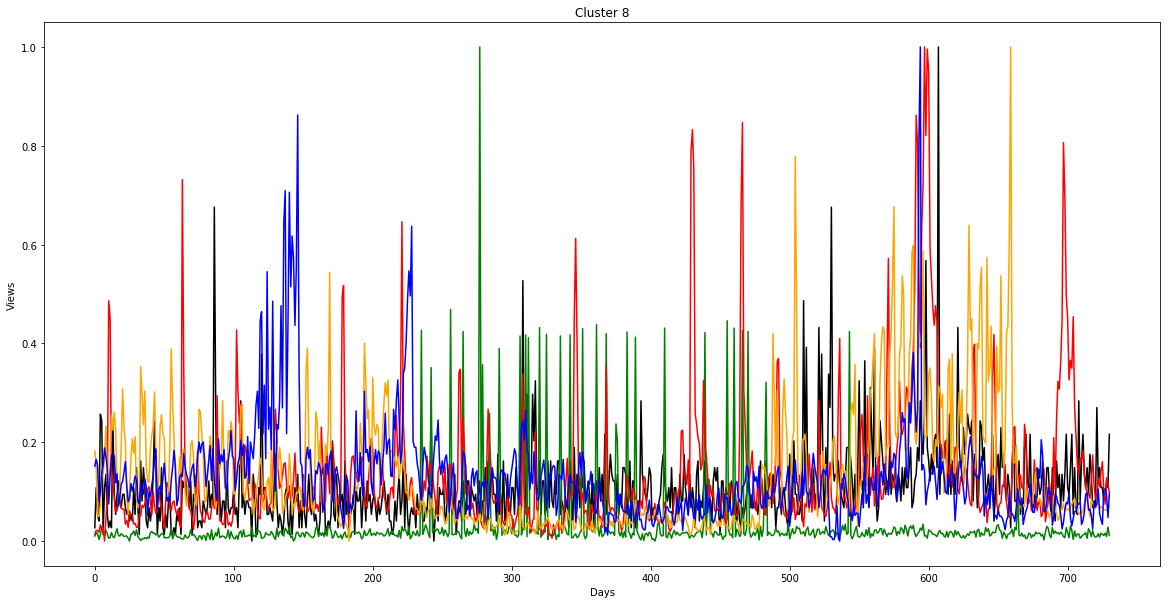

9 => 25569


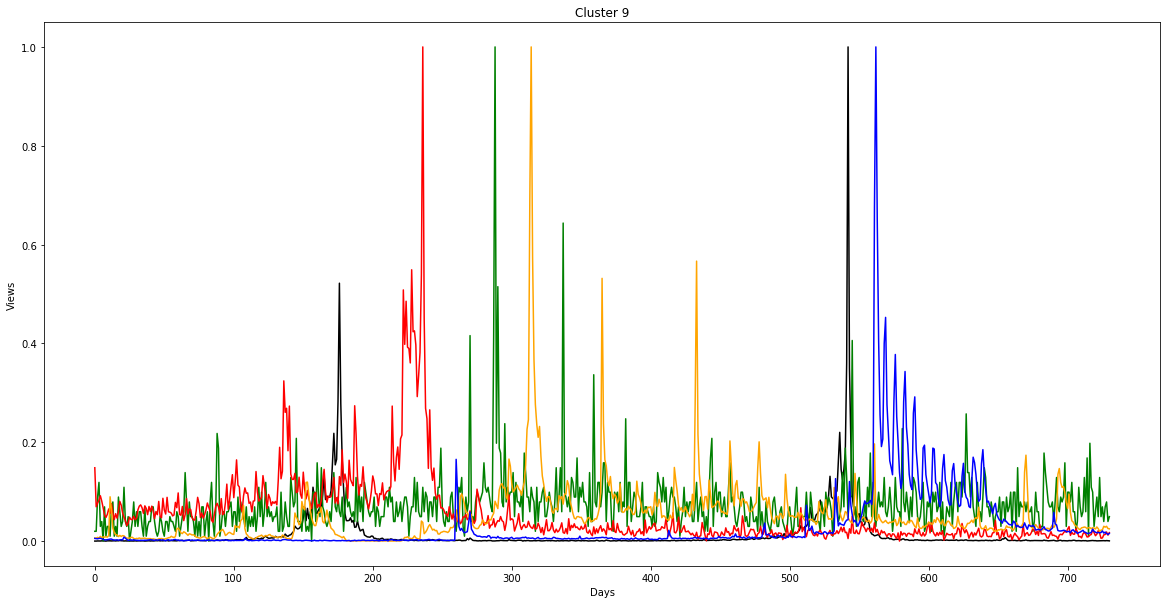

In [148]:
assembled = dtw_training.append(rest_training)
assembled_labels = np.append(labels,labels_rest)

for i in labels_unique:
    count = len(assembled_labels[assembled_labels == i])
    print(f"{i} => {count}")
    plt.figure(figsize=(20,10))
    filtered = assembled[assembled_labels == i]
    for j in range(min(count,5)):
        sample = random.randint(0,len(filtered))
        plot_series(filtered.iloc[sample,:],f"Cluster {i}",new_plot=False,plot_show=False,color=colors[j])
    plt.show()

0 => 20445


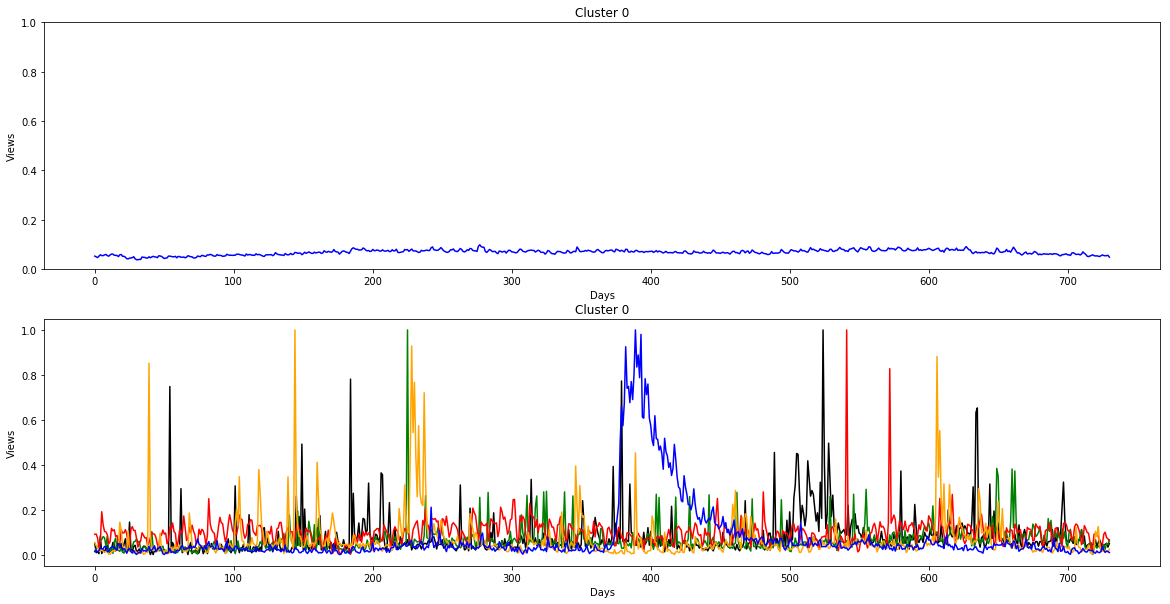

1 => 1976


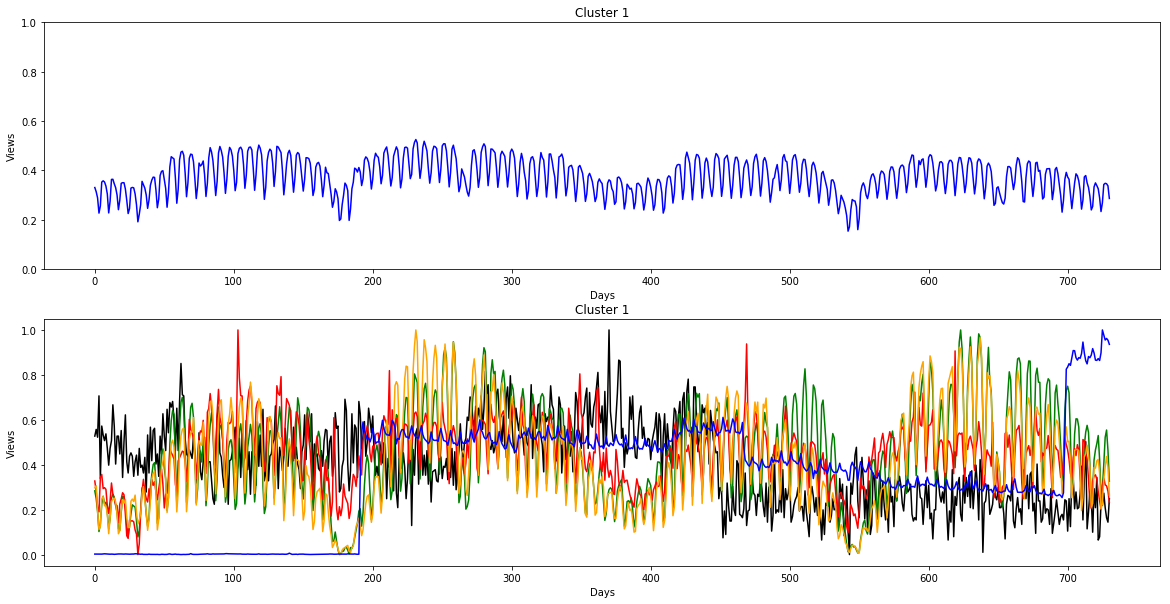

2 => 34873


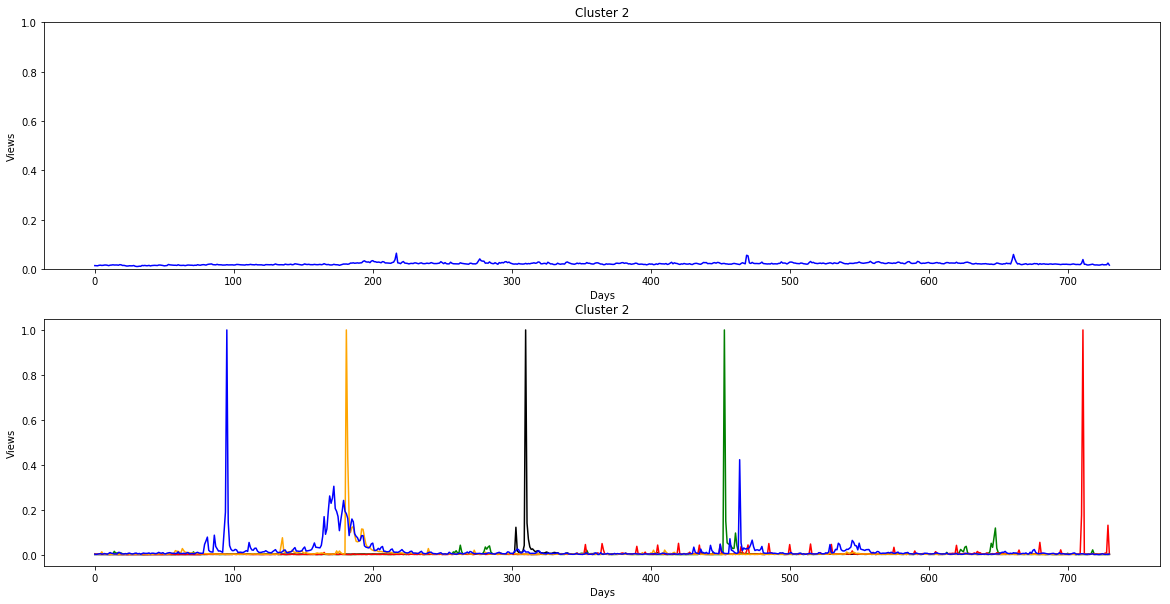

3 => 7370


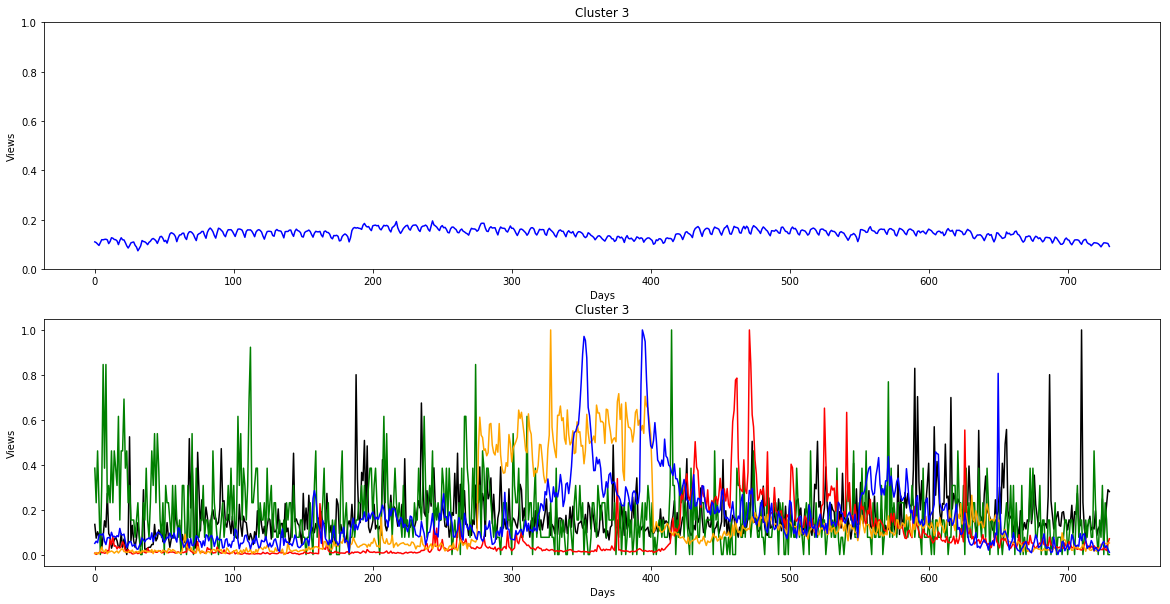

4 => 8933


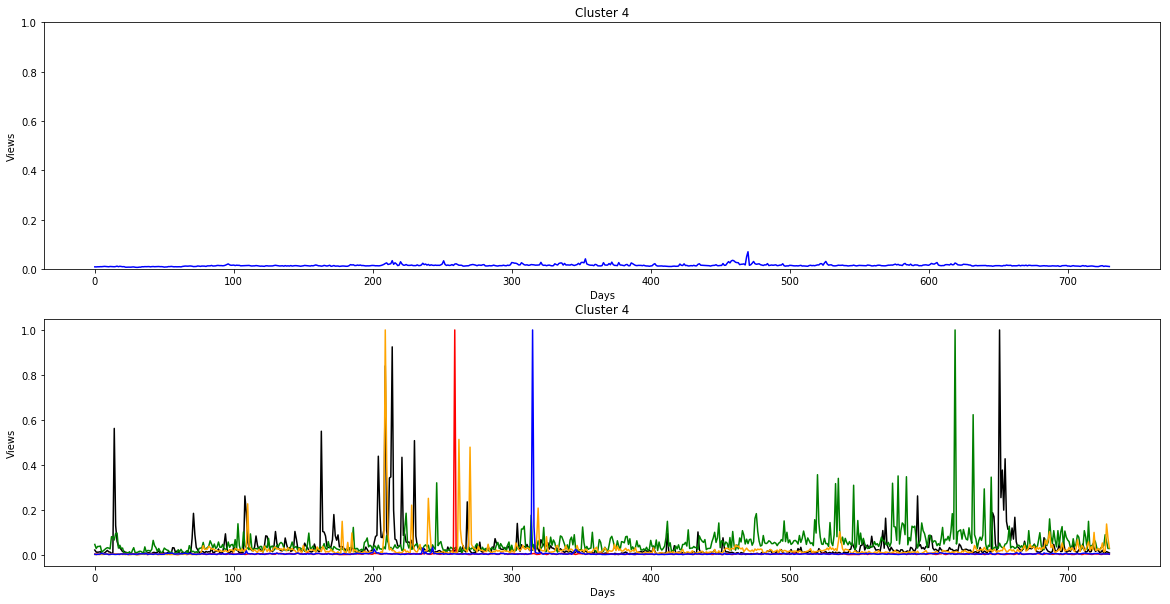

5 => 6264


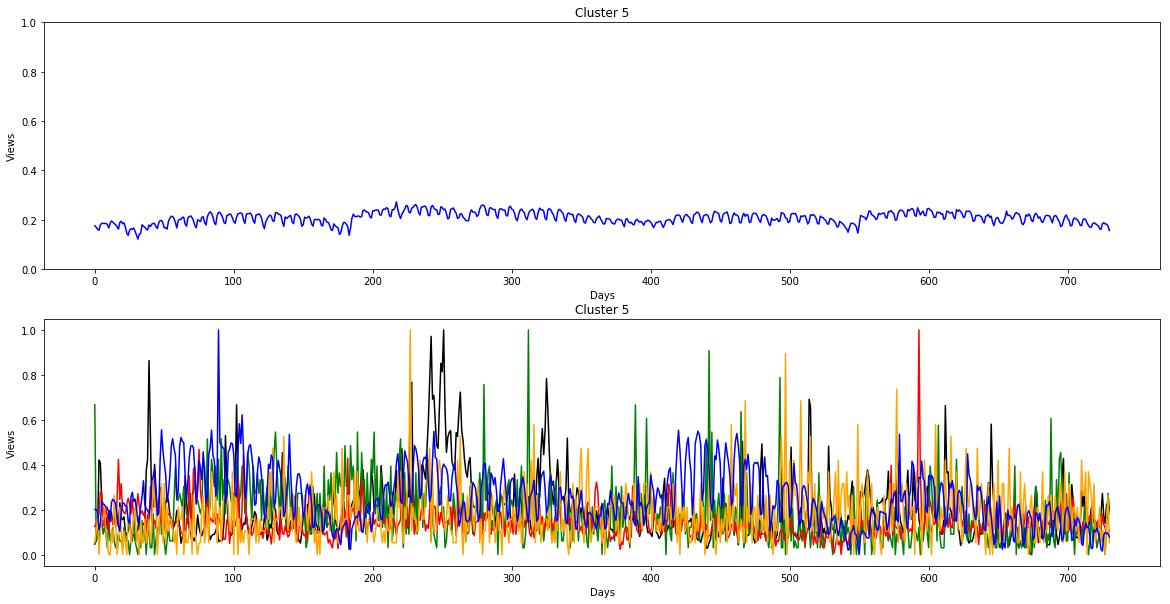

6 => 2014


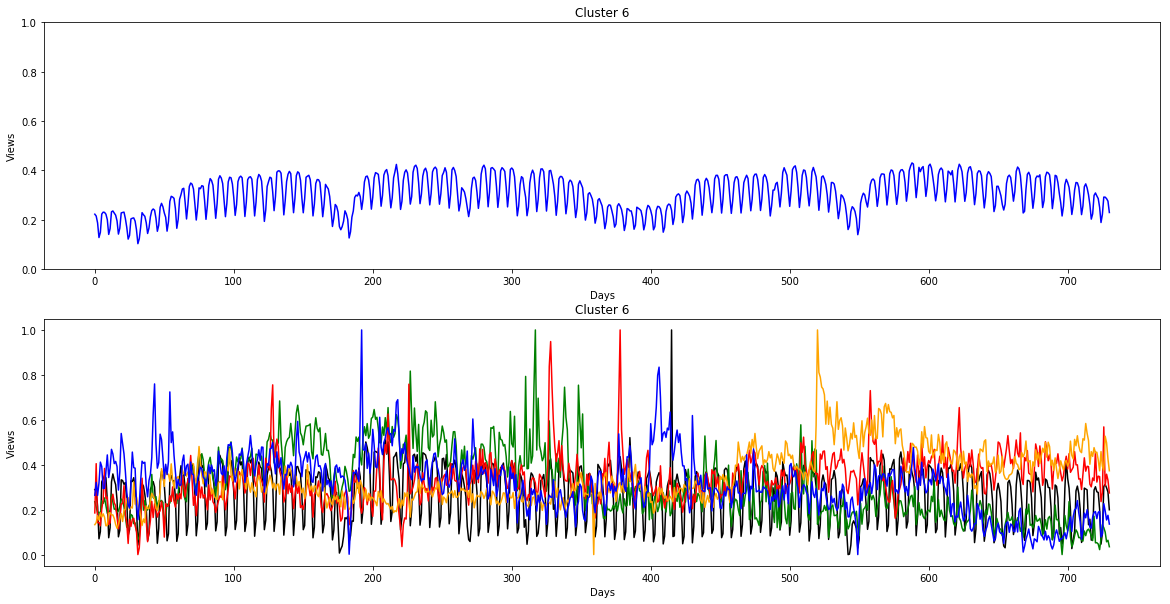

7 => 523


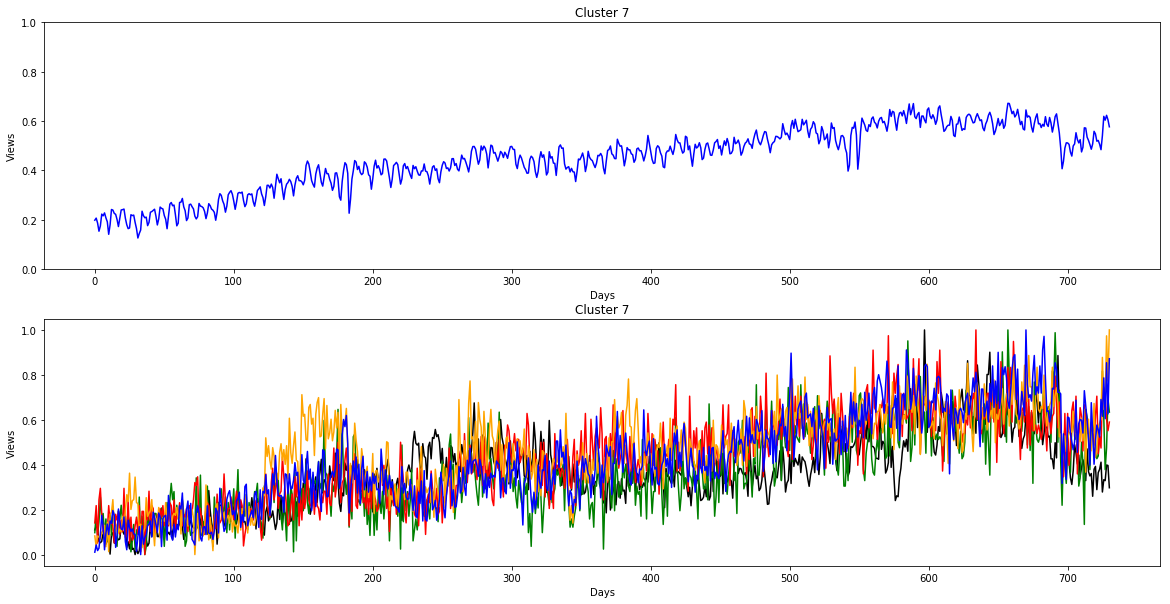

8 => 7117


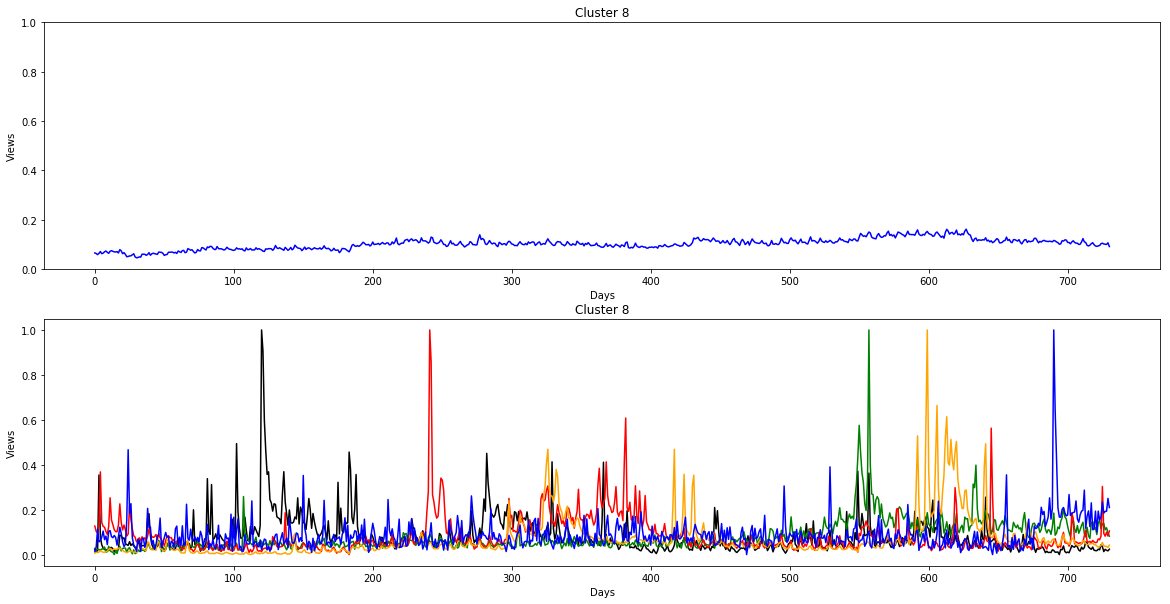

9 => 25569


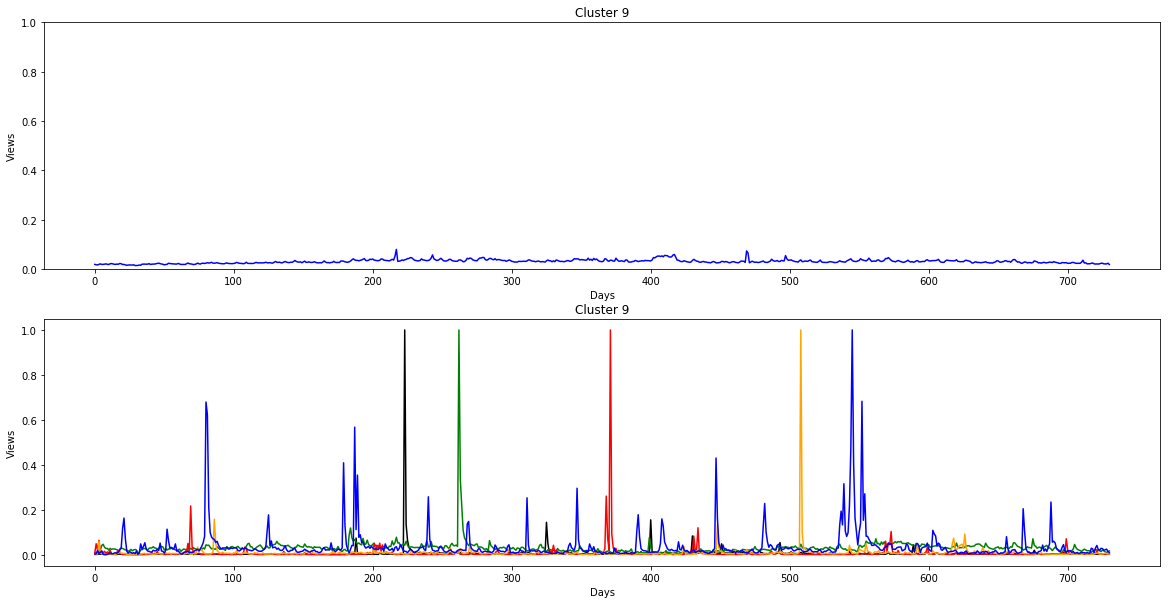

In [149]:
for i in labels_unique:
    count = len(assembled_labels[assembled_labels == i])
    print(f"{i} => {count}")
    filtered = assembled[assembled_labels == i]
    mean = filtered.mean(axis=0)
    plt.figure(figsize=(20,10))
    plt.subplot(2,1,1)
    plt.ylim(0,1)
    plot_series(mean,f"Cluster {i}",new_plot=False,plot_show=False,color='blue')
    plt.subplot(2,1,2)
    for j in range(min(count,5)):
        sample = random.randint(0,len(filtered))
        plot_series(filtered.iloc[sample,:],f"Cluster {i}",new_plot=False,plot_show=False,color=colors[j])
    plt.show()

# Smoothing time series with moving average

In [ ]:
def smooth_series(ts,window):
    ts_rolling = ts.rolling(window=window,min_periods=1)
    ts_smooth = ts_rolling.mean()
    return ts_smooth

In [ ]:
for i in range(5):
    sample = random.randint(0,len(features_dataset))
    ts = features_dataset.iloc[sample,:]
    title = f"{sample} - {meta_dataset.iloc[sample,0]}"
    plot_series(ts,title,label="Standard",plot_show=False)

    window = 7
    ts_smooth = smooth_series(ts,window)
    print(ts_smooth.head(10))
    plot_series(ts_smooth,title,label=f"Smoothed {window}",color='red',plot_show=True,new_plot=False)

## Testing Prophet

In [ ]:
LANG_HOLIDAYS = {
    'es': ['Spain','Argentina', 'Colombia'],
    'de': ['Germany', 'Switzerland','Austria','Luxembourg'],
    'zh': [],
    'na': [],
    'fr': ['France', 'Switzerland', 'Luxembourg', 'Belgium','Canada'],
    'ru': ['Russia'],
    'ja': ['Japan'],
    'en': ['UnitedStates', 'UnitedKingdom', 'Australia', 'Canada', 'Ireland', 'New Zealand', 'Netherlands']
}

In [ ]:
sample = random.randint(0,len(features_dataset))
title = meta_dataset.iloc[sample,0]
lang = meta_dataset.iloc[sample,:]['lang']
print(lang)
ts = train_dataset.iloc[sample,:]
ts_truth = test_dataset.iloc[sample,:]
plot_series(ts,f"Normal starting series - {title}")

In [ ]:
prophet_set = pd.DataFrame({'ds': ts.index.values, 'y': ts.values})
prophet_set.head()

In [ ]:
m_prophet = Prophet()

for l in LANG_HOLIDAYS[lang]:
    m_prophet.add_country_holidays(country_name=l)
m_prophet.fit(prophet_set)

In [ ]:
future_prophet = m_prophet.make_future_dataframe(periods=test_dataset.shape[1]-1)
forecast_prophet = m_prophet.predict(future_prophet)
fig = m_prophet.plot(forecast_prophet)
a = add_changepoints_to_plot(fig.gca(), m_prophet, forecast_prophet)

In [ ]:
fig2 = m_prophet.plot_components(forecast_prophet)

In [ ]:
forecast_prophet.head()

In [ ]:
full = ts.append(ts_truth)
plot_series(full,title="Forecast",label="Ground truth",new_plot=True,plot_show=False)
plt.axvline(len(ts))
plot_series(forecast_prophet['yhat'],title="Forecast",label="Prediction",new_plot=False,plot_show=False,color='red')
plt.fill_between(range(forecast_prophet['yhat'].shape[0]),forecast_prophet['yhat_lower'],forecast_prophet['yhat_upper'])
plt.legend()
plt.show()

# Putting all series together

In [199]:
og_meta_dataset, _, _,_ = train_test_split(meta_dataset,meta_dataset['lang'],train_size=0.01,stratify=meta_dataset['lang'], random_state=42)

In [200]:
og_meta_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1150 entries, 44593 to 79719
Columns: 807 entries, name to 2017-09-10
dtypes: float64(807)
memory usage: 7.1 MB


In [201]:
og_meta_dataset.head()

name  lang  access  agent  2015-07-01  2015-07-02  2015-07-03  \
44593   32607.0   4.0     2.0    0.0      5848.0      6060.0      6073.0   
70873   18366.0   2.0     0.0    0.0       382.0       398.0       285.0   
41631   16957.0   3.0     2.0    0.0       331.0       478.0      1270.0   
71863   12130.0   2.0     0.0    0.0       830.0       604.0       568.0   
114997   5470.0   2.0     0.0    1.0         2.0         1.0         8.0   

        2015-07-04  2015-07-05  2015-07-06     ...      2017-09-01  \
44593       7627.0      7453.0      5524.0     ...          4314.0   
70873        180.0       236.0       415.0     ...          1384.0   
41631       2801.0      2043.0      2498.0     ...           120.0   
71863        948.0       694.0       548.0     ...           846.0   
114997        12.0         3.0         8.0     ...             2.0   

        2017-09-02  2017-09-03  2017-09-04  2017-09-05  2017-09-06  \
44593       4953.0      5107.0      4573.0      4933.0      5019.0   
70873        770.0      1121.0      1889.0      2286.0      1839.0   
41631        170.0       144.0        73.0       131.0       193.0   
71863        325.0      1076.0       758.0      2923.0      1326.0   
114997         4.0         2.0         4.0         4.0         2.0   

        2017-09-07  2017-09-08  2017-09-09  2017-09-10  
44593       4841.0      4483.0      5205.0      5317.0  
70873       1654.0      1059.0       492.0       847.0  
41631        139.0       144.0       224.0       305.0  
71863        599.0       404.0       276.0       206.0  
114997        29.0         6.0         7.0         4.0  

[5 rows x 807 columns]

In [202]:
melted = og_meta_dataset.melt(id_vars=['name','lang','access','agent'],var_name= 'date', value_name='hits')
melted.head()

name  lang  access  agent        date    hits
0  32607.0   4.0     2.0    0.0  2015-07-01  5848.0
1  18366.0   2.0     0.0    0.0  2015-07-01   382.0
2  16957.0   3.0     2.0    0.0  2015-07-01   331.0
3  12130.0   2.0     0.0    0.0  2015-07-01   830.0
4   5470.0   2.0     0.0    1.0  2015-07-01     2.0

In [203]:
melted['date'] = pd.to_datetime(melted['date'])
melted.head()

name  lang  access  agent       date    hits
0  32607.0   4.0     2.0    0.0 2015-07-01  5848.0
1  18366.0   2.0     0.0    0.0 2015-07-01   382.0
2  16957.0   3.0     2.0    0.0 2015-07-01   331.0
3  12130.0   2.0     0.0    0.0 2015-07-01   830.0
4   5470.0   2.0     0.0    1.0 2015-07-01     2.0

In [204]:
def extract_features(df):
    #features = df.copy()
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear
    df['quarter'] = df['date'].dt.quarter
    df['week_of_year'] = df['date'].dt.weekofyear
    #df['holiday_ca'] = df['date'].map(lambda x: False)
    #df = df.merge(df['date'] \
    #.apply(lambda x: pd.Series({'holiday_us': x in holidays.UnitedStates(),'holiday_ja': x in holidays.Japan(),
    #                'holiday_fr': x in holidays.France(),'holiday_ca': x in holidays.Canada(),
    #                  'holiday_es': x in holidays.Spain(),'holiday_uk': x in holidays.UnitedKingdom()})),left_index=True, right_index=True)
    #return features

In [205]:
%%time
extract_features(melted)

CPU times: user 190 ms, sys: 5.55 ms, total: 196 ms
Wall time: 196 ms


In [206]:
melted.head()

name  lang  access  agent       date    hits  day_of_week  month  \
0  32607.0   4.0     2.0    0.0 2015-07-01  5848.0            2      7   
1  18366.0   2.0     0.0    0.0 2015-07-01   382.0            2      7   
2  16957.0   3.0     2.0    0.0 2015-07-01   331.0            2      7   
3  12130.0   2.0     0.0    0.0 2015-07-01   830.0            2      7   
4   5470.0   2.0     0.0    1.0 2015-07-01     2.0            2      7   

   day_of_year  quarter  week_of_year  
0          182        3            27  
1          182        3            27  
2          182        3            27  
3          182        3            27  
4          182        3            27

In [207]:
current_date = '2017-07-01'
train = melted[melted['date'] < current_date]
test = melted[melted['date'] == current_date]
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 840650 entries, 0 to 840649
Data columns (total 11 columns):
name            840650 non-null float64
lang            840650 non-null float64
access          840650 non-null float64
agent           840650 non-null float64
date            840650 non-null datetime64[ns]
hits            840650 non-null float64
day_of_week     840650 non-null int64
month           840650 non-null int64
day_of_year     840650 non-null int64
quarter         840650 non-null int64
week_of_year    840650 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(5)
memory usage: 77.0 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1150 entries, 840650 to 841799
Data columns (total 11 columns):
name            1150 non-null float64
lang            1150 non-null float64
access          1150 non-null float64
agent           1150 non-null float64
date            1150 non-null datetime64[ns]
hits            1150 non-null float64
day_of_week     1150 non-null int

In [208]:
train.head()

name  lang  access  agent       date    hits  day_of_week  month  \
0  32607.0   4.0     2.0    0.0 2015-07-01  5848.0            2      7   
1  18366.0   2.0     0.0    0.0 2015-07-01   382.0            2      7   
2  16957.0   3.0     2.0    0.0 2015-07-01   331.0            2      7   
3  12130.0   2.0     0.0    0.0 2015-07-01   830.0            2      7   
4   5470.0   2.0     0.0    1.0 2015-07-01     2.0            2      7   

   day_of_year  quarter  week_of_year  
0          182        3            27  
1          182        3            27  
2          182        3            27  
3          182        3            27  
4          182        3            27

In [209]:
test.head()

name  lang  access  agent       date    hits  day_of_week  month  \
840650  32607.0   4.0     2.0    0.0 2017-07-01  7472.0            5      7   
840651  18366.0   2.0     0.0    0.0 2017-07-01   229.0            5      7   
840652  16957.0   3.0     2.0    0.0 2017-07-01  4207.0            5      7   
840653  12130.0   2.0     0.0    0.0 2017-07-01   137.0            5      7   
840654   5470.0   2.0     0.0    1.0 2017-07-01    14.0            5      7   

        day_of_year  quarter  week_of_year  
840650          182        3            26  
840651          182        3            26  
840652          182        3            26  
840653          182        3            26  
840654          182        3            26

In [210]:
mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01,categorical_feature=[0,1,2,3])
scaler = MinMaxScaler()
mdl.fit(train.drop(columns=['hits','date']),np.log1p(train['hits']))

/Users/maximelovino/Documents/LOCAL_CODE/WikiForecasting/venv/lib/python3.7/site-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


LGBMRegressor(boosting_type='gbdt', categorical_feature=[0, 1, 2, 3],
              class_weight=None, colsample_bytree=1.0, importance_type='split',
              learning_rate=0.01, max_depth=-1, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
              n_jobs=-1, num_leaves=31, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [211]:
p = mdl.predict(test.drop(columns=['hits','date']))

In [212]:
p = np.expm1(p)
p = np.maximum(p,0)

In [213]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [214]:
print("Error %.5f" % (rmsle(test['hits'],p)))

Error 0.64321


/Users/maximelovino/Documents/LOCAL_CODE/WikiForecasting/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


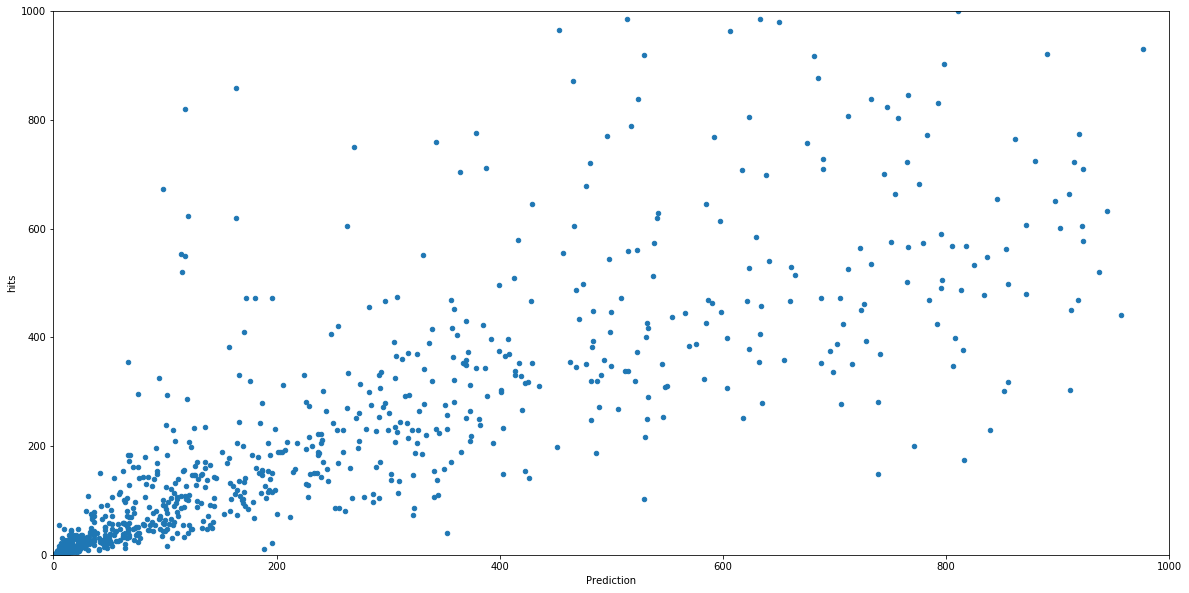

In [215]:
test['Prediction'] = np.round(p)
lim = 1000
test.plot.scatter(x='Prediction',y='hits',ylim=(0,lim), xlim=(0,lim),figsize=(20,10))